<a href="https://colab.research.google.com/github/AsminPothula/BandSense/blob/main/Asmin_Colab_Starting_Point.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
!pip install pymongo
!pip install pyts
!pip install fastdtw
!pip install tsfresh
!pip install tslearn
!pip install sktime
import tsfresh
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters
from pymongo import MongoClient
from pprint import pprint
import pytz, itertools, re
from datetime import datetime
import json, os, math, random
from pytz import timezone
from bson import json_util
import pandas as pd
import numpy as np
from collections.abc import MutableMapping
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, signal
from sklearn.linear_model import LinearRegression
from google.colab import data_table
from scipy import stats
def clean(varStr): return re.sub('\W|^(?=\d)','_', varStr)
from fastdtw import fastdtw
import scipy.signal as signal
from sklearn.cluster import KMeans
from pyts.classification import TimeSeriesForest
from typing import List
from scipy.spatial.distance import euclidean
from scipy.signal import correlate
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
import tslearn.metrics as ts_metrics
from scipy import signal
import scipy.stats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.9/492.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB 15.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 5.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=517917 sha256=491a3ae93f4c48b9d24a7c73dbd8682a89ad4708becf4f5d9786d0d9614848d4
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw
Looking in indexes: https://pypi.org/simpl

# MongoDB Connection Credentials

In [ ]:
servers = {
  "cloud": "ws://162.243.120.86:443",
  "lab": "ws://192.168.1.5:3001",
  "home": "ws://192.168.1.221:3001"
}
mongoconfig = {"mongoaddr":"138.68.230.2", "mongoport":27017, "mongouser":"hybridatelier", "mongopass": "ERB281282", "mongoauth":"admin", "dbname":"bandsense"}
print("MONGO CONFIG")
pprint(mongoconfig)
client = MongoClient(host=mongoconfig["mongoaddr"], port=mongoconfig["mongoport"],username=mongoconfig["mongouser"],password=mongoconfig["mongopass"])
db = client[mongoconfig["dbname"]]


# Get a list of the collections in the database
collections = db.list_collection_names()

# Print the names of the collections
print(collections)

# Iterate through each collection and get a list of the fields in the collection
for collection in collections:
    document = db[collection].find_one()
    if document:
        fields = document.keys()
        print(collection, fields)
    else:
        print(collection, "is empty")

MONGO CONFIG
{'dbname': 'bandsense',
 'mongoaddr': '138.68.230.2',
 'mongoauth': 'admin',
 'mongopass': 'ERB281282',
 'mongoport': 27017,
 'mongouser': 'hybridatelier'}
['test', 'gestures']
test dict_keys(['_id', 'user_id', 'measurement_task_id', 'form_results'])
gestures dict_keys(['_id', 'labels', 'start_time', 'end_time', 'data'])


# Helper Functions

In [ ]:
class trigger:
  def find(collection, query, projection = {}):
    print("Looking at %s for %s"%(collection, str(query)))
    results = db[collection].find(query, projection)
    return list(results)

def flow_df(collection, query={}, projection={"_id": 0}):
  records = trigger.find(collection, query, projection)
  flat_records = [flatten_json(r) for r in records]
  df =  pd.DataFrame(flat_records)
  return df

def retrieve_documents(read_collection, query):
  records = list(read_collection.find(query))
  return records

def flatten_json(y):
  out = {}

  def flatten(x, name=''):
      if type(x) is dict:
          for a in x:
              flatten(x[a], name + a + '_')
      elif type(x) is list:
          i = 0
          for a in x:
              flatten(a, name + str(i) + '_')
              i += 1
      else:
          out[name[:-1]] = x

  flatten(y)
  return out

# BandSense Raw Data: Resistence

In [ ]:
collection = db["gestures"]
docs = retrieve_documents(collection, query={})
data = pd.DataFrame(docs)
#data

# BandSense Preprocessed Data


In [ ]:
# Calculate duration of the event
data['end_time'] = data['end_time'] - data['start_time']

# Assign 0 to rows where start_time == 0, and then assign 0 to the start_time column
data['start_time'] = data['start_time'] == 0
data['start_time'] = 0

# Drop rows with specified index and reset the index
data = data.drop([15,16,17,18,30,38,39,40,46])
data = data.reset_index(drop=True)

In [ ]:
# Creating a new DataFrame "gesturedata" by selecting rows from the original data
gesturedata = pd.DataFrame(data[15:38])

# Resetting the index of the new DataFrame to start from 0
gesturedata = gesturedata.reset_index(drop=True)

In [ ]:
# Define a function to smooth the data using a moving average window
def smooth_demo(lst):
  window_size = 7
  i = 0
  smooth_values = []
  while i < len(lst) - window_size + 1:
    # Calculate the average of the values in the window
    window_average = round(np.sum(lst[i:i+window_size]) / window_size, 2)
    # Append the average to the list of smooth values
    smooth_values.append(window_average)
    i += 1
  # Return the list of smooth values
  return smooth_values

# Apply the smooth_demo function to the 'data' column of the 'gesturedata' DataFrame and store the results in a new 'smooth_data' column
gesturedata['smooth_data'] = gesturedata['data'].apply(lambda x: smooth_demo(x))

#gesturedata = gesturedata.drop(['data'],axis=1)

In [ ]:
# Extract data from gesturedata DataFrame
x = gesturedata['data'][0]
y = gesturedata['data'][12]

# Convert data to numpy arrays
x = np.array(x)
y= np.array(y)

#gesturedata

In [ ]:
# Define a function that creates a new time array based on input parameters
def newtime(x: List[float], start_time: float, end_time: float) -> List[float]:
    # Get the number of x values
    num_x_values = len(x)
    # Calculate the interval size between each time value
    interval_size = (end_time - start_time) / (num_x_values - 1)
    # Generate a time array with the calculated interval size and start and end times
    time = np.arange(start_time, end_time+interval_size, interval_size).tolist()[:num_x_values]
    # Return the time array
    return time

# Apply the newtime function to create a new 'time' column in the 'gesturedata' DataFrame
gesturedata['time'] = gesturedata.apply(lambda row: newtime(row['smooth_data'], row['start_time'], row['end_time']), axis=1)

# Apply the newtime function to create a new 'min' column in the 'gesturedata' DataFrame
gesturedata['min'] = gesturedata['data'].apply(lambda x: min(x))

# Apply the newtime function to create a new 'max' column in the 'gesturedata' DataFrame
gesturedata['max'] = gesturedata['data'].apply(lambda x: max(x))

def mean(x):
  y = np.array(x)
  y.mean()
  return y.mean()
# Apply the newtime function to create a new 'mean' column in the 'gesturedata' DataFrame
gesturedata['mean'] = gesturedata['data'].apply(lambda x: mean(x))

def variance(x):
  y = np.array(x)
  y.var()
  return y.var()
# Apply the newtime function to create a new 'variance' column in the 'gesturedata' DataFrame
gesturedata['variance'] = gesturedata['data'].apply(lambda x: variance(x))

def std(x):
    y = np.array(x)
    return y.std()
# Apply the newtime function to create a new 'std' column in the 'gesturedata' DataFrame
gesturedata['std'] = gesturedata['data'].apply(lambda x: std(x))

def skew(x):
    y = np.array(x)
    return scipy.stats.skew(y)
# Apply the newtime function to create a new 'skew' column in the 'gesturedata' DataFrame
gesturedata['skew'] = gesturedata['data'].apply(lambda x: skew(x))


In [ ]:
gesturedata

,_id,labels,start_time,end_time,data,smooth_data,time,min,max,mean,variance,std,skew
0,642cba40f6318311604d2a1b,"[AP, F1, TRIAL1]",0,27,"[16.22950745, 15.16854, 16.58461571, 15.875127...","[16.59, 17.31, 18.34, 19.43, 20.73, 21.92, 22....","[0.0, 0.021704180064308683, 0.0434083601286173...",14.114053,24.957985,20.808872,10.374952,3.221017,-0.733337
1,642cba8cf6318311604d2a1c,"[AP, F1, TRIAL2]",0,27,"[20.53941917, 20.53941917, 22.73486519, 21.268...","[21.22, 21.37, 21.43, 21.11, 21.06, 20.96, 21....","[0.0, 0.019522776572668113, 0.0390455531453362...",14.464830,26.080084,21.670799,11.747311,3.427435,-0.780636
2,642cbad6f6318311604d2a1d,"[AP, F1, TRIAL3]",0,24,"[21.26819229, 20.53941917, 20.53941917, 20.903...","[20.64, 20.64, 20.7, 20.7, 20.75, 20.75, 20.8,...","[0.0, 0.01937046004842615, 0.0387409200968523,...",14.114053,27.966103,22.424759,14.090221,3.753694,-0.762733
3,642cbb03f6318311604d2a1e,"[AP, F1, TRIAL4]",0,23,"[22, 22.36705017, 22.36705017, 22, 22.36705017...","[22.05, 22.0, 22.0, 21.84, 21.9, 21.84, 21.9, ...","[0.0, 0.020087336244541485, 0.0401746724890829...",14.464830,29.872206,23.195831,17.216517,4.149279,-0.676597
4,642cbb38f6318311604d2a1f,"[AP, F1, TRIAL5]",0,27,"[26.83210182, 26.45569611, 26.83210182, 25.705...","[26.19, 26.08, 25.97, 25.87, 25.87, 25.76, 25....","[0.0, 0.018633540372670808, 0.0372670807453416...",15.168540,30.640343,24.339691,19.373958,4.401586,-0.763852
5,642cbc8bf6318311604d2a20,"[AD, F1, TRIAL0]",0,25,"[20.90342712, 21.26819229, 20.17616653, 20.903...","[20.75, 20.75, 20.75, 20.85, 20.8, 20.7, 20.8,...","[0.0, 0.01893939393939394, 0.03787878787878788...",13.065989,27.587299,21.359893,20.221921,4.496879,-0.400762
6,642cbcc2f6318311604d2a21,"[AD, F1, TRIAL1]",0,22,"[22.36705017, 21.63371468, 22, 21.26819229, 22...","[21.74, 21.63, 21.69, 21.69, 21.69, 21.58, 21....","[0.0, 0.018949181739879414, 0.0378983634797588...",13.065989,27.587299,20.782574,20.871580,4.568542,-0.237188
7,642cbd02f6318311604d2a22,"[AD, F1, TRIAL2]",0,23,"[23.10344887, 23.10344887, 23.10344887, 23.103...","[23.05, 23.05, 23.1, 23.1, 23.05, 23.1, 23.1, ...","[0.0, 0.019246861924686193, 0.0384937238493723...",14.816326,28.726116,22.126012,21.495863,4.636363,-0.348626
8,642cbd28f6318311604d2a23,"[AD, F1, TRIAL3]",0,25,"[24.21383667, 24.21383667, 23.84293175, 24.213...","[24.43, 24.53, 24.59, 24.8, 24.85, 24.85, 24.9...","[0.0, 0.01849112426035503, 0.03698224852071006...",15.168540,30.255861,23.135769,23.815033,4.880065,-0.471552
9,642cbd4bf6318311604d2a24,"[AD, F1, TRIAL4]",0,24,"[22, 22.36705017, 22.36705017, 22, 22.73486519...","[22.26, 22.31, 22.31, 22.26, 22.26, 22.16, 22....","[0.0, 0.018867924528301886, 0.0377358490566037...",14.114053,29.872206,22.363672,24.896618,4.989651,-0.351576


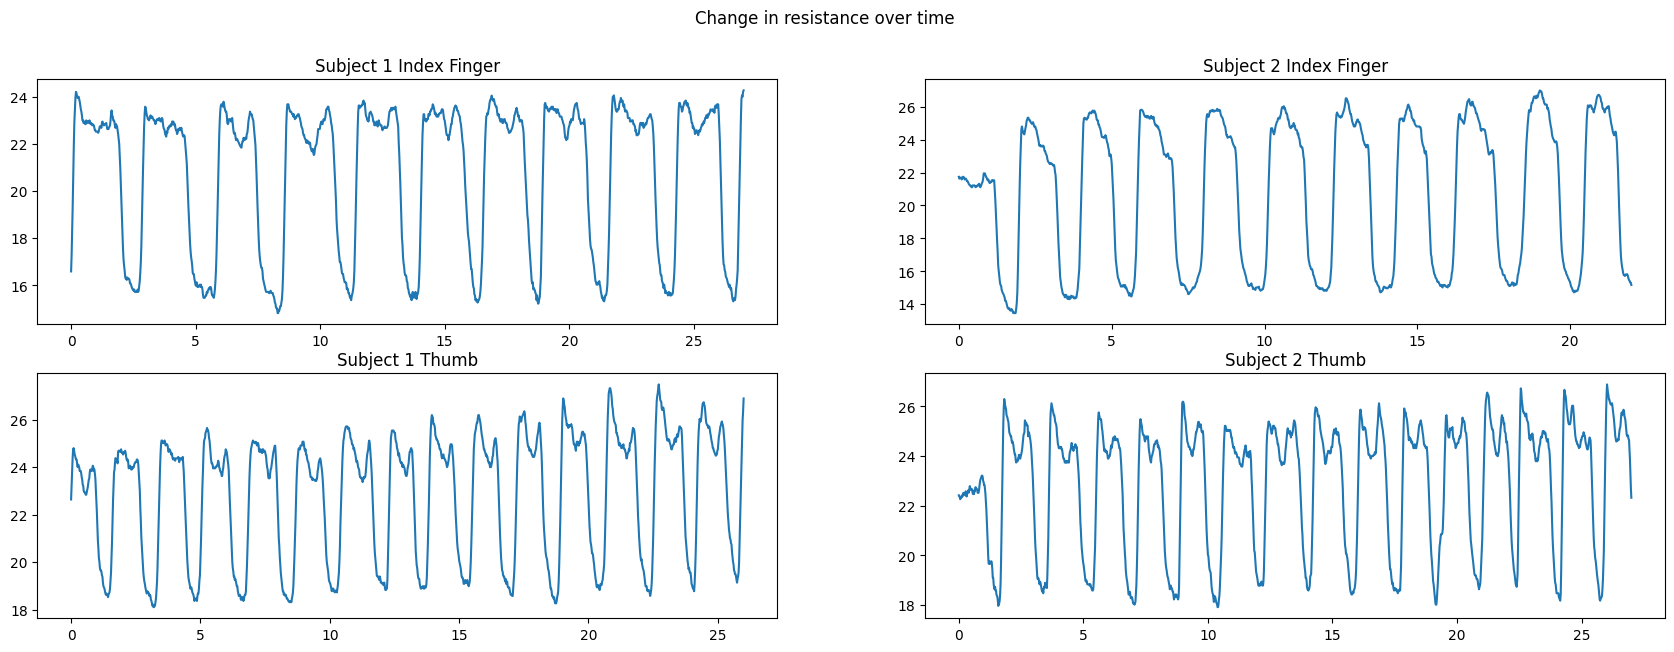

In [ ]:
#Assign the time values for each subject's index finger and thumb to x1, x2, x3, x4
x1 = gesturedata['time'][0]
x2 = gesturedata['time'][6]
x3 = gesturedata['time'][12]
x4 = gesturedata['time'][18]

#x1 = gesturedata['time'][0]
#x2 = gesturedata['time'][6]
#x3 = gesturedata['time'][12]
#x4 = gesturedata['time'][18]

#Assign the corresponding smooth data values for each subject's index finger and thumb to y1, y2, y3, y4
y1 = gesturedata['smooth_data'][0]
y2 = gesturedata['smooth_data'][6]
y3 = gesturedata['smooth_data'][12]
y4 = gesturedata['smooth_data'][18]

# Create a figure and four subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(21,7))

# Plot the first subplot using Seaborn's lineplot function
sns.lineplot(x=x1, y=y1, ax=axes[0, 0])
axes[0, 0].set_title('Subject 1 Index Finger')

# Plot the second subplot using Seaborn's lineplot function
sns.lineplot(x=x2, y=y2, ax=axes[0, 1])
axes[0, 1].set_title('Subject 2 Index Finger')

# Plot the third subplot using Seaborn's lineplot function
sns.lineplot(x=x3, y=y3, ax=axes[1, 0])
axes[1, 0].set_title('Subject 1 Thumb')

# Plot the fourth subplot using Seaborn's lineplot function
sns.lineplot(x=x4, y=y4, ax=axes[1, 1])
axes[1, 1].set_title('Subject 2 Thumb')

# Add a title to the figure
fig.suptitle('Change in resistance over time')

# Show the figure
plt.show()


[16.59, 17.31, 18.34, 19.43, 20.73, 21.92, 22.9, 23.48, 23.95, 24.21, 24.16, 24.0, 23.95, 24.0, 24.0, 23.9, 23.79, 23.63, 23.47, 23.37, 23.21, 23.0, 23.0, 22.89, 22.89, 22.95, 22.84, 22.84, 23.0, 22.95, 22.89, 22.95, 22.95, 22.89, 23.0, 22.89, 22.84, 22.89, 22.84, 22.79, 22.84, 22.79, 22.79, 22.68, 22.58, 22.58, 22.52, 22.52, 22.52, 22.52, 22.47, 22.52, 22.63, 22.74, 22.74, 22.74, 22.68, 22.89, 22.95, 22.84, 22.79, 22.79, 22.84, 22.84, 22.84, 22.89, 22.74, 22.63, 22.63, 22.63, 22.68, 22.74, 22.79, 23.0, 23.32, 23.42, 23.21, 23.16, 23.0, 23.0, 22.95, 22.79, 22.68, 22.84, 22.79, 22.74, 22.58, 22.42, 22.21, 22.0, 21.48, 20.96, 20.29, 19.67, 19.0, 18.22, 17.55, 17.1, 16.84, 16.64, 16.38, 16.28, 16.33, 16.23, 16.33, 16.28, 16.28, 16.28, 16.23, 16.08, 16.08, 16.03, 15.93, 15.88, 15.82, 15.82, 15.77, 15.82, 15.72, 15.72, 15.72, 15.72, 15.72, 15.82, 15.72, 15.77, 15.98, 16.18, 16.54, 17.0, 17.71, 18.8, 19.88, 20.87, 21.8, 22.69, 23.26, 23.58, 23.53, 23.37, 23.21, 23.16, 23.05, 23.05, 23.0, 23.

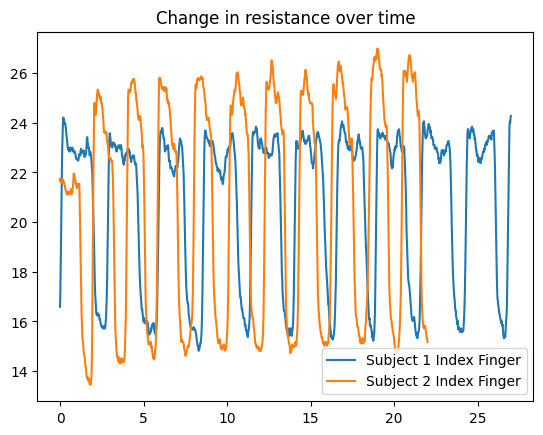

In [ ]:
# Assign the time values for each subject's index finger and thumb to x1, x2, x3, x4
x1 = gesturedata['time'][0]
x2 = gesturedata['time'][6]

# Assign the corresponding smooth data values for each subject's index finger and thumb to y1, y2, y3, y4
y1 = gesturedata['smooth_data'][0]
y2 = gesturedata['smooth_data'][6]

print(y1)
# Plot both data sets on the same subplot using Seaborn's lineplot function
sns.lineplot(x=x1, y=y1, label='Subject 1 Index Finger')
sns.lineplot(x=x2, y=y2, label='Subject 2 Index Finger')

# Add a legend to the plot
plt.legend()

# Add a title to the figure
plt.title('Change in resistance over time')

# Show the figure
plt.show()


In [ ]:
# Assign the time values for each subject's index finger and thumb to x1, x2, x3, x4
x1 = gesturedata['time'][0]
x2 = gesturedata['time'][6]

# Assign the corresponding smooth data values for each subject's index finger and thumb to y1, y2, y3, y4
y1 = gesturedata['smooth_data'][0]
y2 = gesturedata['smooth_data'][6]

# Create a new list for time values and combine them
x_combined = x1 + x2
print(y_combined)
# Create a new list for smooth data values and combine them
y_combined = y1 + y2

# Plot the combined data on a single graph
sns.lineplot(x=x_combined, y=y_combined)

# Add a legend to the plot
plt.legend(['Subject 1 Index Finger', 'Subject 2 Index Finger'])

# Add a title to the figure
plt.title('Change in resistance over time')

# Show the figure
plt.show()


NameError: ignored

# Feature Extraction

In [ ]:
print(gesturedata.dtypes)

_id             object
labels          object
start_time       int64
end_time         int64
data            object
smooth_data     object
time            object
min            float64
max            float64
mean           float64
variance       float64
std            float64
skew           float64
dtype: object


In [ ]:
def zero_crossings(lst):
    zero_crossings = np.where(np.diff(np.signbit(lst)))[0]
    return len(zero_crossings)

def peaks(lst):
    peaks, _ = signal.find_peaks(lst)
    return len(peaks)

import numpy as np
from scipy import signal

def valleys(lst):
    valleys, _ = signal.find_peaks(-np.array(lst))
    return len(valleys)

gesturedata['zero_crossings'] = gesturedata['smooth_data'].apply(lambda x: zero_crossings(x))
gesturedata['peaks'] = gesturedata['smooth_data'].apply(lambda x: peaks(x))
gesturedata['valleys'] = gesturedata['smooth_data'].apply(lambda x: valleys(x))
gesturedata

,_id,labels,start_time,end_time,data,smooth_data,time,min,max,mean,variance,std,skew,zero_crossings,peaks,valleys
0,642cba40f6318311604d2a1b,"[AP, F1, TRIAL1]",0,27,"[16.22950745, 15.16854, 16.58461571, 15.875127...","[16.59, 17.31, 18.34, 19.43, 20.73, 21.92, 22....","[0.0, 0.021704180064308683, 0.0434083601286173...",14.114053,24.957985,20.808872,10.374952,3.221017,-0.733337,0,151,151
1,642cba8cf6318311604d2a1c,"[AP, F1, TRIAL2]",0,27,"[20.53941917, 20.53941917, 22.73486519, 21.268...","[21.22, 21.37, 21.43, 21.11, 21.06, 20.96, 21....","[0.0, 0.019522776572668113, 0.0390455531453362...",14.464830,26.080084,21.670799,11.747311,3.427435,-0.780636,0,133,133
2,642cbad6f6318311604d2a1d,"[AP, F1, TRIAL3]",0,24,"[21.26819229, 20.53941917, 20.53941917, 20.903...","[20.64, 20.64, 20.7, 20.7, 20.75, 20.75, 20.8,...","[0.0, 0.01937046004842615, 0.0387409200968523,...",14.114053,27.966103,22.424759,14.090221,3.753694,-0.762733,0,117,116
3,642cbb03f6318311604d2a1e,"[AP, F1, TRIAL4]",0,23,"[22, 22.36705017, 22.36705017, 22, 22.36705017...","[22.05, 22.0, 22.0, 21.84, 21.9, 21.84, 21.9, ...","[0.0, 0.020087336244541485, 0.0401746724890829...",14.464830,29.872206,23.195831,17.216517,4.149279,-0.676597,0,111,112
4,642cbb38f6318311604d2a1f,"[AP, F1, TRIAL5]",0,27,"[26.83210182, 26.45569611, 26.83210182, 25.705...","[26.19, 26.08, 25.97, 25.87, 25.87, 25.76, 25....","[0.0, 0.018633540372670808, 0.0372670807453416...",15.168540,30.640343,24.339691,19.373958,4.401586,-0.763852,0,142,142
5,642cbc8bf6318311604d2a20,"[AD, F1, TRIAL0]",0,25,"[20.90342712, 21.26819229, 20.17616653, 20.903...","[20.75, 20.75, 20.75, 20.85, 20.8, 20.7, 20.8,...","[0.0, 0.01893939393939394, 0.03787878787878788...",13.065989,27.587299,21.359893,20.221921,4.496879,-0.400762,0,131,130
6,642cbcc2f6318311604d2a21,"[AD, F1, TRIAL1]",0,22,"[22.36705017, 21.63371468, 22, 21.26819229, 22...","[21.74, 21.63, 21.69, 21.69, 21.69, 21.58, 21....","[0.0, 0.018949181739879414, 0.0378983634797588...",13.065989,27.587299,20.782574,20.871580,4.568542,-0.237188,0,111,111
7,642cbd02f6318311604d2a22,"[AD, F1, TRIAL2]",0,23,"[23.10344887, 23.10344887, 23.10344887, 23.103...","[23.05, 23.05, 23.1, 23.1, 23.05, 23.1, 23.1, ...","[0.0, 0.019246861924686193, 0.0384937238493723...",14.816326,28.726116,22.126012,21.495863,4.636363,-0.348626,0,98,98
8,642cbd28f6318311604d2a23,"[AD, F1, TRIAL3]",0,25,"[24.21383667, 24.21383667, 23.84293175, 24.213...","[24.43, 24.53, 24.59, 24.8, 24.85, 24.85, 24.9...","[0.0, 0.01849112426035503, 0.03698224852071006...",15.168540,30.255861,23.135769,23.815033,4.880065,-0.471552,0,106,105
9,642cbd4bf6318311604d2a24,"[AD, F1, TRIAL4]",0,24,"[22, 22.36705017, 22.36705017, 22, 22.73486519...","[22.26, 22.31, 22.31, 22.26, 22.26, 22.16, 22....","[0.0, 0.018867924528301886, 0.0377358490566037...",14.114053,29.872206,22.363672,24.896618,4.989651,-0.351576,0,87,86


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

def plot_data_with_peaks_valleys(gesturedata):
    # Create a new figure
    fig, ax = plt.subplots()

    # Plot the 'smooth_data' column
    ax.plot(np.array(gesturedata['smooth_data']), color='blue', label='Smooth Data')

    # Add markers for peaks and valleys
    peaks, _ = signal.find_peaks(gesturedata['smooth_data'])
    valleys, _ = signal.find_peaks(-gesturedata['smooth_data'])
    ax.plot(peaks, gesturedata['smooth_data'][peaks], "x", color='red', label='Peaks')
    ax.plot(valleys, gesturedata['smooth_data'][valleys], "o", color='green', label='Valleys')

    # Set the axis labels and legend
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.legend()

    # Show the plot
    plt.show()

ValueError: ignored

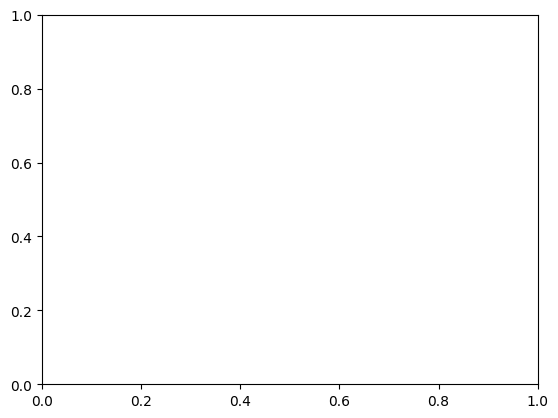

In [ ]:
plot_data_with_peaks_valleys(gesturedata)

In [ ]:
import numpy as np
import pandas as pd

def zero_crossings(x):
    """Calculate the number of zero crossings in the signal"""
    return (np.diff(np.sign(x)) != 0).sum()

def peaks(x):
    """Calculate the number of peaks in the signal"""
    return len(signal.find_peaks(x)[0])

def valleys(x):
    """Calculate the number of valleys in the signal"""
    return len(signal.find_peaks(-x)[0])

# Example usage:
data = [1, 2, 3, 2, 1, 0, -1, -2, -3, -2, -1, 0, 1, 2, 3, 4]
num_zero_crossings = zero_crossings(data)
num_peaks = peaks(data)
num_valleys = valleys(data)

print(f"Number of zero crossings: {num_zero_crossings}")
print(f"Number of peaks: {num_peaks}")
print(f"Number of valleys: {num_valleys}")

TypeError: ignored

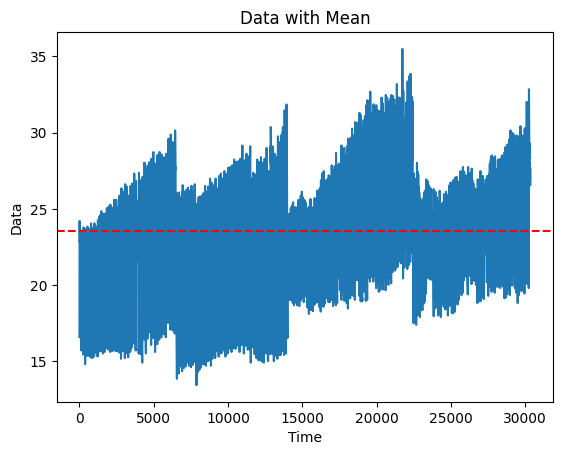

In [ ]:
# Extract the 'data' column from the DataFrame
data = np.concatenate(gesturedata['smooth_data']).astype(float)

# Calculate the mean of the data
mean = np.mean(data)

# Plot the data and the mean
fig, ax = plt.subplots()
ax.plot(data)
ax.axhline(mean, color='r', linestyle='--')
ax.set_xlabel('Time')
ax.set_ylabel('Data')
ax.set_title('Data with Mean')
plt.show()

#practise


In [ ]:
s1 = np.array(gesturedata['data'][0])
s2 = np.array(gesturedata['data'][11])

s1_resampled = np.interp(np.linspace(0, 1, len(s2)), np.linspace(0, 1, len(s1)), s1)
s2_resampled = s2

X = np.vstack((s1_resampled, s2_resampled))
y = np.hstack((np.zeros(len(s1_resampled)), np.ones(len(s2_resampled))))

from sklearn.model_selection import train_test_split

print(X.shape)
print(y.shape)

(2, 1282)
(2564,)


In [ ]:
s1 = np.array(gesturedata['data'][0])
s2 = np.array(gesturedata['data'][11])

s1_resampled = np.interp(np.linspace(0, 1, len(s2)), np.linspace(0, 1, len(s1)), s1)
s2_resampled = s2

X = np.vstack((s1_resampled, s2_resampled))
y = np.hstack((np.zeros(len(s1_resampled)), np.ones(len(s2_resampled))))

from sklearn.model_selection import train_test_split

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from pyts.classification import TimeSeriesForest

tsf = TimeSeriesForest(n_estimators=100, random_state=42)
tsf.fit(X_train, y_train)

y_pred = tsf.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)



(2, 1282)
(2564,)


ValueError: ignored

#Spectrogram - trail

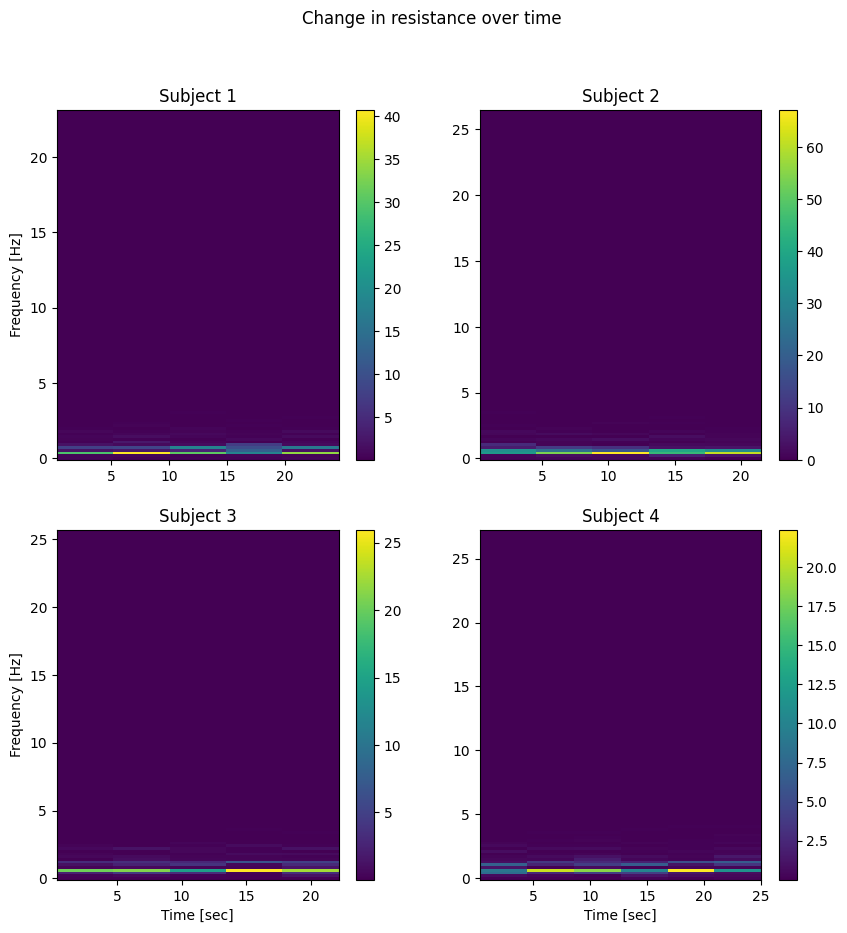

In [ ]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Assign the time values for each subject's index finger and thumb to x1, x2, x3, x4
x1 = gesturedata['time'][0]
x2 = gesturedata['time'][6]
x3 = gesturedata['time'][12]
x4 = gesturedata['time'][18]

# Assign the corresponding smooth data values for each subject's index finger and thumb to y1, y2, y3, y4
y1 = gesturedata['smooth_data'][0]
y2 = gesturedata['smooth_data'][6]
y3 = gesturedata['smooth_data'][12]
y4 = gesturedata['smooth_data'][18]

# Convert y to a numpy array
y1 = np.array(y1)
y2 = np.array(y2)
y3 = np.array(y3)
y4 = np.array(y4)

# Compute the spectrogram for each signal
frequencies1, times1, spectrogram1 = signal.spectrogram(y1, fs=1/(x1[1]-x1[0]))
frequencies2, times2, spectrogram2 = signal.spectrogram(y2, fs=1/(x2[1]-x2[0]))
frequencies3, times3, spectrogram3 = signal.spectrogram(y3, fs=1/(x3[1]-x3[0]))
frequencies4, times4, spectrogram4 = signal.spectrogram(y4, fs=1/(x4[1]-x4[0]))

# Plot the spectrograms
plt.figure(figsize=(10, 10))

plt.subplot(221)
plt.pcolormesh(times1, frequencies1, spectrogram1)
plt.ylabel('Frequency [Hz]')
plt.title('Subject 1')
plt.colorbar()

plt.subplot(222)
plt.pcolormesh(times2, frequencies2, spectrogram2)
plt.title('Subject 2')
plt.colorbar()

plt.subplot(223)
plt.pcolormesh(times3, frequencies3, spectrogram3)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Subject 3')
plt.colorbar()

plt.subplot(224)
plt.pcolormesh(times4, frequencies4, spectrogram4)
plt.xlabel('Time [sec]')
plt.title('Subject 4')
plt.colorbar()

plt.suptitle('Change in resistance over time')
plt.show()

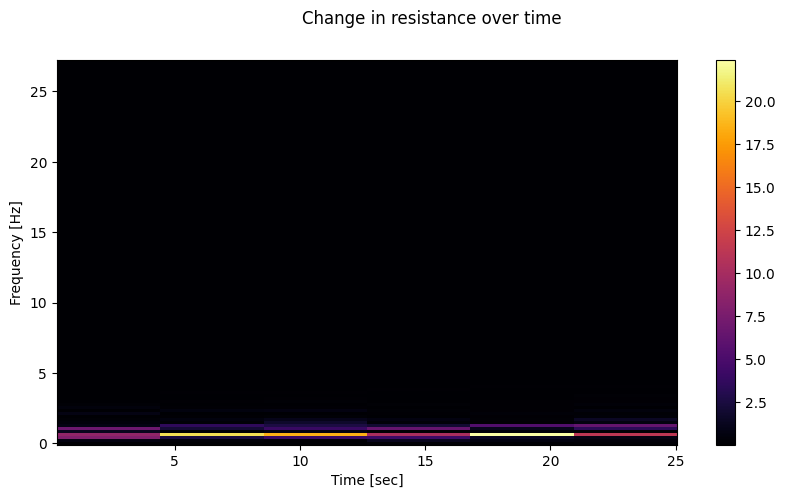

In [ ]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Assign the time values for each subject's index finger and thumb to x1, x2, x3, x4
x1 = gesturedata['time'][0]
x2 = gesturedata['time'][6]
x3 = gesturedata['time'][12]
x4 = gesturedata['time'][18]

# Assign the corresponding smooth data values for each subject's index finger and thumb to y1, y2, y3, y4
y1 = gesturedata['smooth_data'][0]
y2 = gesturedata['smooth_data'][6]
y3 = gesturedata['smooth_data'][12]
y4 = gesturedata['smooth_data'][18]

# Convert y1 to a numpy array
y1 = np.array(y1)
y2 = np.array(y2)
y3 = np.array(y3)
y4 = np.array(y4)

# Compute the spectrogram for each signal
frequencies1, times1, spectrogram1 = signal.spectrogram(y1, fs=1/(x1[1]-x1[0]))
frequencies2, times2, spectrogram2 = signal.spectrogram(y2, fs=1/(x2[1]-x2[0]))
frequencies3, times3, spectrogram3 = signal.spectrogram(y3, fs=1/(x3[1]-x3[0]))
frequencies4, times4, spectrogram4 = signal.spectrogram(y4, fs=1/(x4[1]-x4[0]))

# Plot the spectrograms
fig, ax = plt.subplots(figsize=(10, 5))

im1 = ax.pcolormesh(times1, frequencies1, spectrogram1, shading='auto', cmap='inferno')
im2 = ax.pcolormesh(times2, frequencies2, spectrogram2, shading='auto', cmap='inferno')
im3 = ax.pcolormesh(times3, frequencies3, spectrogram3, shading='auto', cmap='inferno')
im4 = ax.pcolormesh(times4, frequencies4, spectrogram4, shading='auto', cmap='inferno')

# Set the axis labels
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [sec]')

# Create a colorbar
fig.colorbar(im4, ax=ax)

# Add a title to the figure
fig.suptitle('Change in resistance over time')

# Show the figure
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

# Assign the time values for each subject's index finger and thumb to x1, x2, x3, x4
x1 = gesturedata['time'][0]
x2 = gesturedata['time'][6]
x3 = gesturedata['time'][12]
x4 = gesturedata['time'][18]

# Assign the corresponding smooth data values for each subject's index finger and thumb to y1, y2, y3, y4
y1 = gesturedata['smooth_data'][0]
y2 = gesturedata['smooth_data'][6]
y3 = gesturedata['smooth_data'][12]
y4 = gesturedata['smooth_data'][18]

# Convert y1 to a numpy array
y1 = np.array(y1)
y2 = np.array(y2)
y3 = np.array(y3)
y4 = np.array(y4)

# Compute the spectrogram for each signal
spectrogram1 = librosa.feature.melspectrogram(y1, sr=int(1/(x1[1]-x1[0])))
spectrogram2 = librosa.feature.melspectrogram(y2, sr=int(1/(x2[1]-x2[0])))
spectrogram3 = librosa.feature.melspectrogram(y3, sr=int(1/(x3[1]-x3[0])))
spectrogram4 = librosa.feature.melspectrogram(y4, sr=int(1/(x4[1]-x4[0])))


# Convert spectrograms to dB scale
spectrogram1 = librosa.amplitude_to_db(spectrogram1, ref=np.max)
spectrogram2 = librosa.amplitude_to_db(spectrogram2, ref=np.max)
spectrogram3 = librosa.amplitude_to_db(spectrogram3, ref=np.max)
spectrogram4 = librosa.amplitude_to_db(spectrogram4, ref=np.max)

# Get the corresponding time values for each spectrogram
times1 = librosa.times_like(spectrogram1)
times2 = librosa.times_like(spectrogram2)
times3 = librosa.times_like(spectrogram3)
times4 = librosa.times_like(spectrogram4)

# Get the corresponding frequency values for each spectrogram
frequencies1 = librosa.core.mel_frequencies(n_mels=spectrogram1.shape[0])
frequencies2 = librosa.core.mel_frequencies(n_mels=spectrogram2.shape[0])
frequencies3 = librosa.core.mel_frequencies(n_mels=spectrogram3.shape[0])
frequencies4 = librosa.core.mel_frequencies(n_mels=spectrogram4.shape[0])

# Plot the spectrograms
fig, ax = plt.subplots(figsize=(10, 5))

im1 = ax.pcolormesh(times1, frequencies1, spectrogram1, shading='auto', cmap='inferno')
im2 = ax.pcolormesh(times2, frequencies2, spectrogram2, shading='auto', cmap='inferno')
im3 = ax.pcolormesh(times3, frequencies3, spectrogram3, shading='auto', cmap='inferno')
im4 = ax.pcolormesh(times4, frequencies4, spectrogram4, shading='auto', cmap='inferno')


TypeError: ignored

# Spectrogram - trail 2


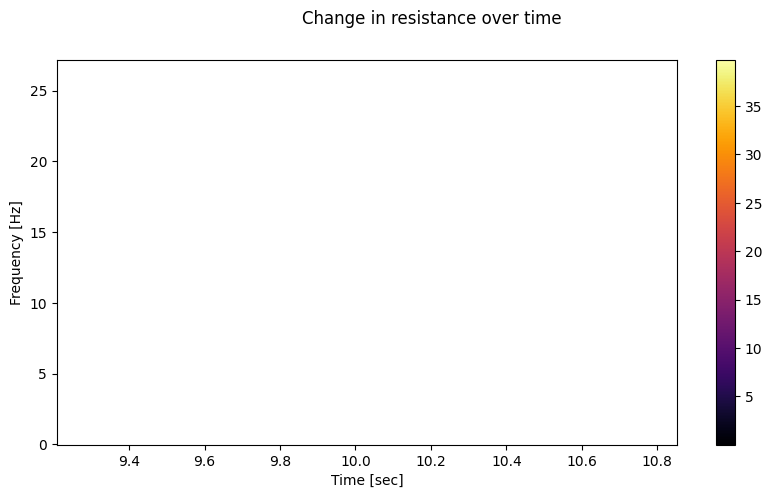

In [ ]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Assign the time values for each subject's index finger and thumb to x1, x2, x3, x4
x1 = gesturedata['time'][0]
x2 = gesturedata['time'][6]
x3 = gesturedata['time'][12]
x4 = gesturedata['time'][18]

# Assign the corresponding smooth data values for each subject's index finger and thumb to y1, y2, y3, y4
y1 = gesturedata['smooth_data'][0]
y2 = gesturedata['smooth_data'][6]
y3 = gesturedata['smooth_data'][12]
y4 = gesturedata['smooth_data'][18]

# Convert y1 to a numpy array
y1 = np.array(y1)
y2 = np.array(y2)
y3 = np.array(y3)
y4 = np.array(y4)

# Set the window size and overlap
window_size = 1000
overlap = 500

# Compute the spectrogram for each signal with rolling windows and overlap
frequencies1, times1, spectrogram1 = signal.spectrogram(y1, fs=1/(x1[1]-x1[0]), window='hann', nperseg=window_size, noverlap=overlap)
frequencies2, times2, spectrogram2 = signal.spectrogram(y2, fs=1/(x2[1]-x2[0]), window='hann', nperseg=window_size, noverlap=overlap)
frequencies3, times3, spectrogram3 = signal.spectrogram(y3, fs=1/(x3[1]-x3[0]), window='hann', nperseg=window_size, noverlap=overlap)
frequencies4, times4, spectrogram4 = signal.spectrogram(y4, fs=1/(x4[1]-x4[0]), window='hann', nperseg=window_size, noverlap=overlap)

# Plot the spectrograms
fig, ax = plt.subplots(figsize=(10, 5))

im1 = ax.pcolormesh(times1, frequencies1, spectrogram1, shading='auto', cmap='inferno')
im2 = ax.pcolormesh(times2, frequencies2, spectrogram2, shading='auto', cmap='inferno')
im3 = ax.pcolormesh(times3, frequencies3, spectrogram3, shading='auto', cmap='inferno')
im4 = ax.pcolormesh(times4, frequencies4, spectrogram4, shading='auto', cmap='inferno')

# Set the axis labels
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [sec]')

# Create a colorbar
fig.colorbar(im4, ax=ax)

# Add a title to the figure
fig.suptitle('Change in resistance over time')

# Show the figure
plt.show()

In [ ]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns

# Define the window size and overlap for the rolling window
window_size = 1024
overlap = window_size // 2

# Define the timeframes to use
timeframes = [0.5, 1, 2, 3, 4, 5]  # in seconds

# Assign the time values for each subject's index finger and thumb to x1, x2, x3, x4
x1 = gesturedata['time'][0]
x2 = gesturedata['time'][6]
x3 = gesturedata['time'][12]
x4 = gesturedata['time'][18]

# Assign the corresponding smooth data values for each subject's index finger and thumb to y1, y2, y3, y4
y1 = gesturedata['smooth_data'][0]
y2 = gesturedata['smooth_data'][6]
y3 = gesturedata['smooth_data'][12]
y4 = gesturedata['smooth_data'][18]

# Define a function to compute the spectrograms for a given timeframe
def compute_spectrogram(y, timeframe):
    # Compute the number of samples in the timeframe
    n_samples = int(timeframe / (x1[1] - x1[0]))
    # Compute the number of samples that overlap
    n_overlap = int(n_samples * 0.5)
    # Compute the spectrogram with the given parameters
    frequencies, times, spectrogram = signal.spectrogram(np.array(y), fs=1/(x[1]-x[0]), window='hann', nperseg=window_size, noverlap=overlap)
    return frequencies, times, spectrogram

# Compute the spectrograms for each timeframe and signal
spectrograms = []
for y in [y1, y2, y3, y4]:
    y_spectrograms = []
    for timeframe in timeframes:
        frequencies, times, spectrogram = compute_spectrogram(y, timeframe)
        y_spectrograms.append(spectrogram)
    spectrograms.append(np.array(y_spectrograms))

# Print the shape of the computed spectrograms
for i, y in enumerate([y1, y2, y3, y4]):
    for j, timeframe in enumerate(timeframes):
        print(f"Subject {i+1}, timeframe {timeframe}s: {spectrograms[i][j].shape}")

# TODO: Train the CNN on the spectrograms and compare the performance for different timeframes


Subject 1, timeframe 0.5s: (513, 1)
Subject 1, timeframe 1s: (513, 1)
Subject 1, timeframe 2s: (513, 1)
Subject 1, timeframe 3s: (513, 1)
Subject 1, timeframe 4s: (513, 1)
Subject 1, timeframe 5s: (513, 1)
Subject 2, timeframe 0.5s: (513, 1)
Subject 2, timeframe 1s: (513, 1)
Subject 2, timeframe 2s: (513, 1)
Subject 2, timeframe 3s: (513, 1)
Subject 2, timeframe 4s: (513, 1)
Subject 2, timeframe 5s: (513, 1)
Subject 3, timeframe 0.5s: (513, 1)
Subject 3, timeframe 1s: (513, 1)
Subject 3, timeframe 2s: (513, 1)
Subject 3, timeframe 3s: (513, 1)
Subject 3, timeframe 4s: (513, 1)
Subject 3, timeframe 5s: (513, 1)
Subject 4, timeframe 0.5s: (513, 1)
Subject 4, timeframe 1s: (513, 1)
Subject 4, timeframe 2s: (513, 1)
Subject 4, timeframe 3s: (513, 1)
Subject 4, timeframe 4s: (513, 1)
Subject 4, timeframe 5s: (513, 1)


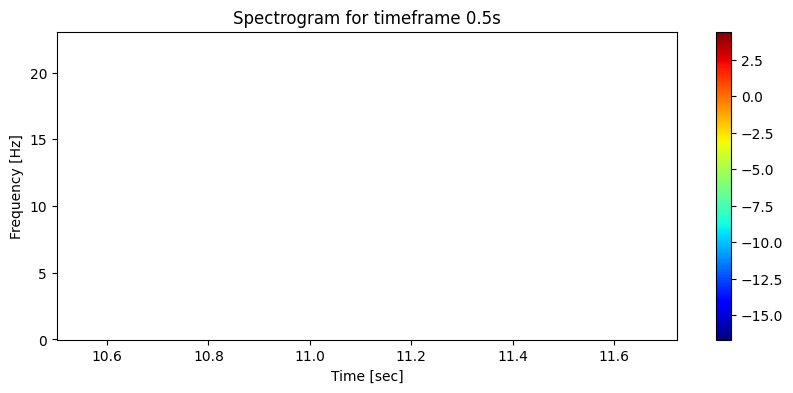

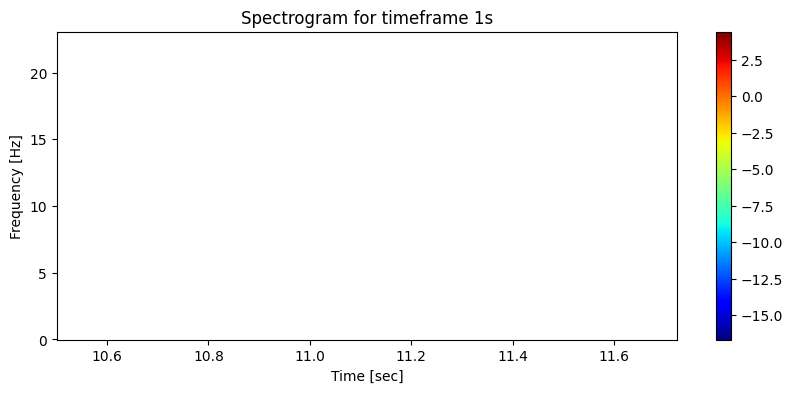

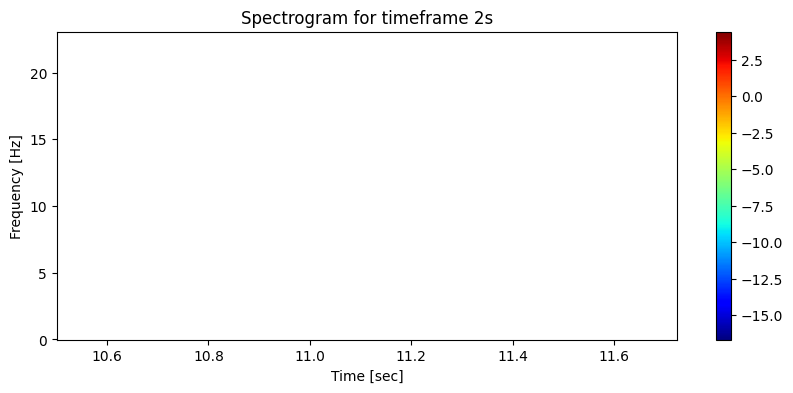

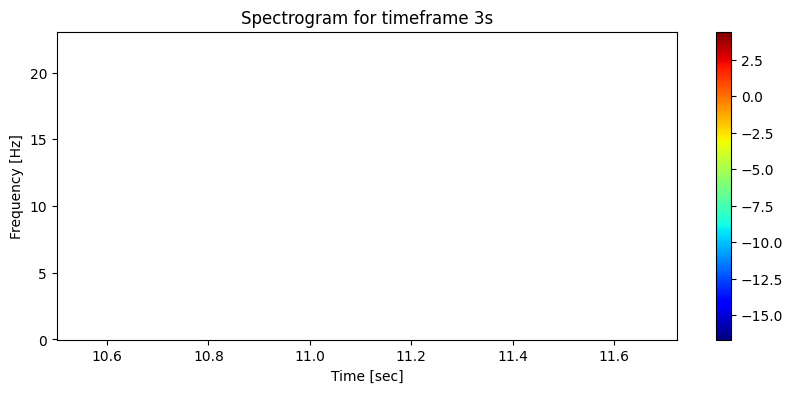

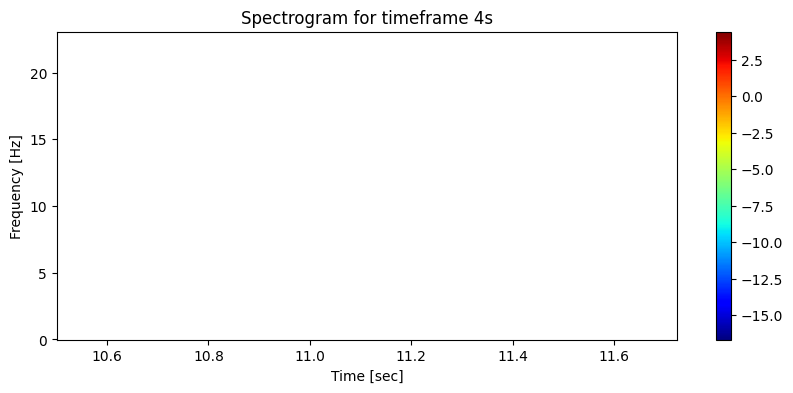

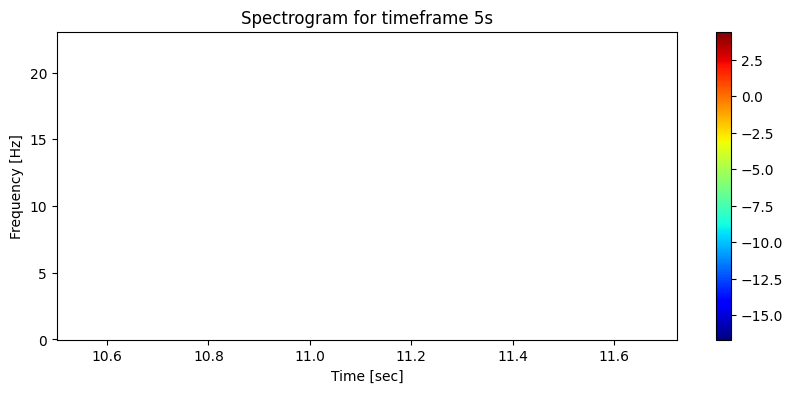

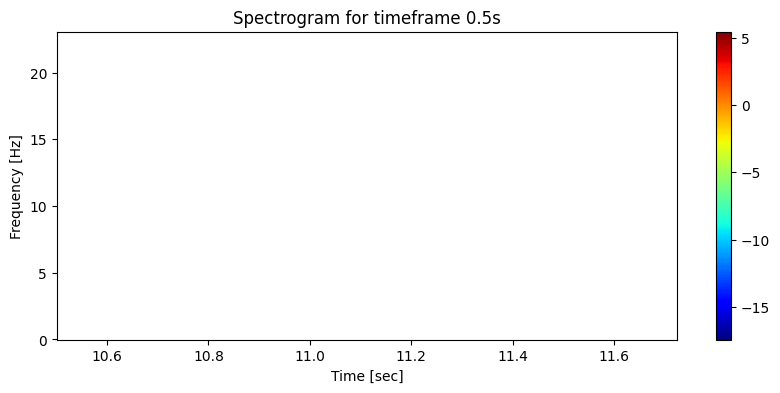

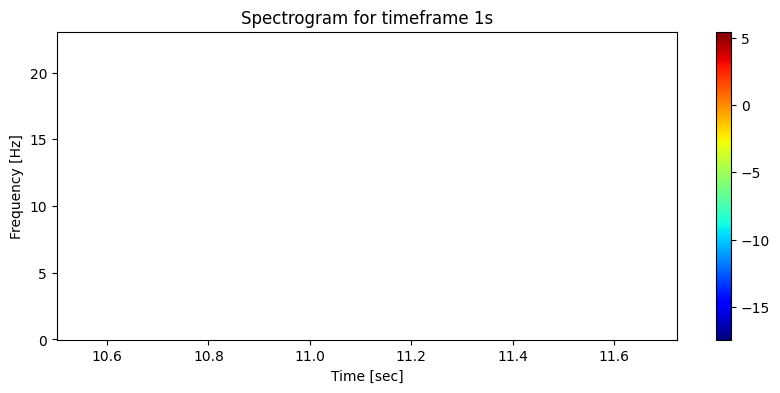

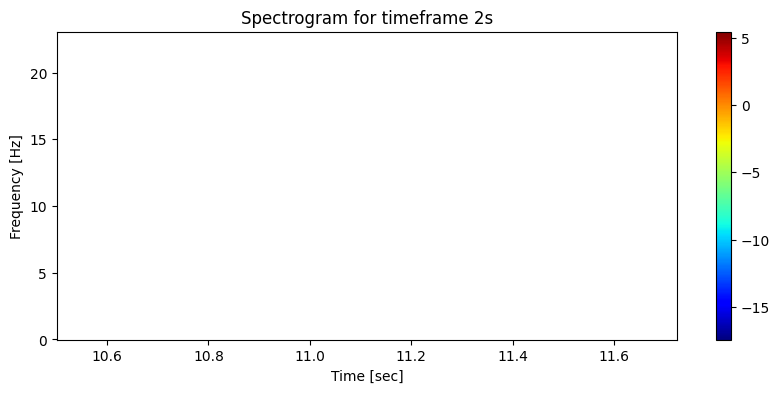

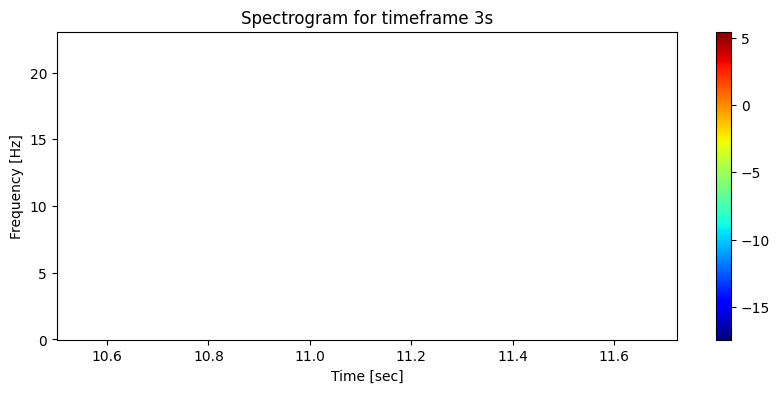

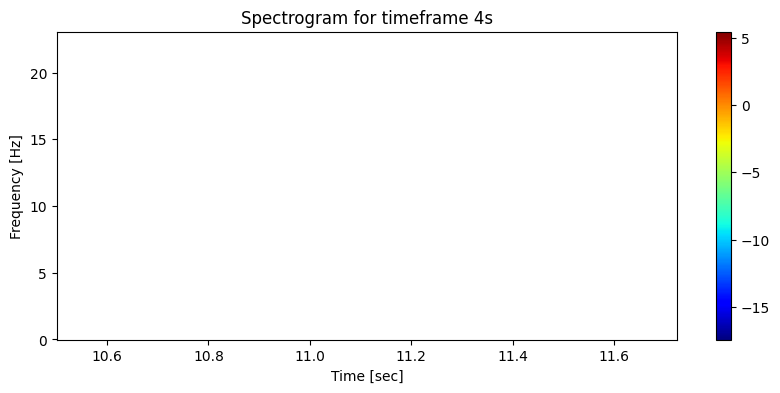

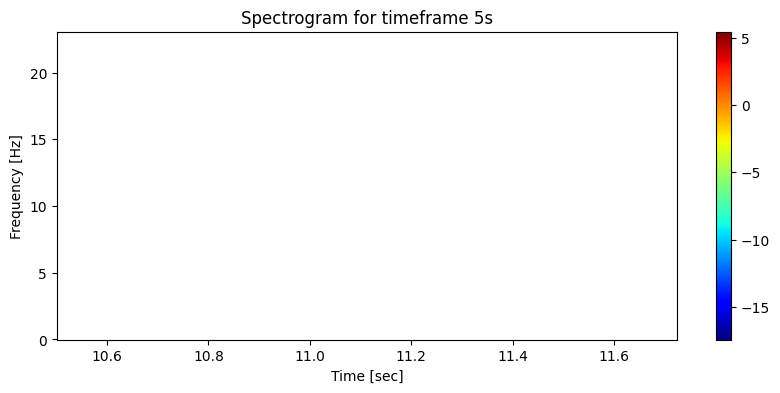

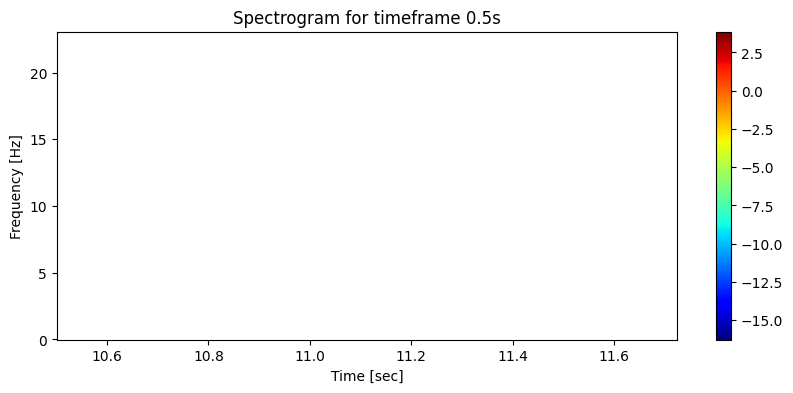

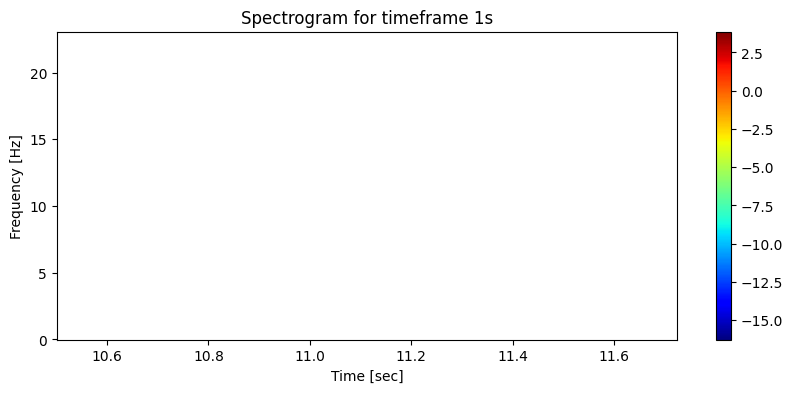

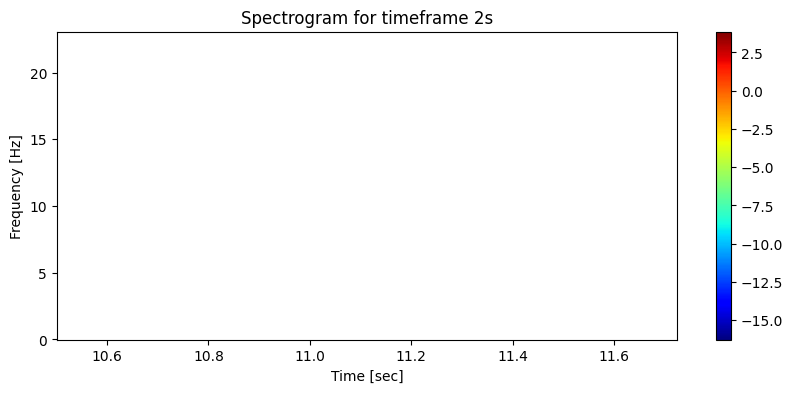

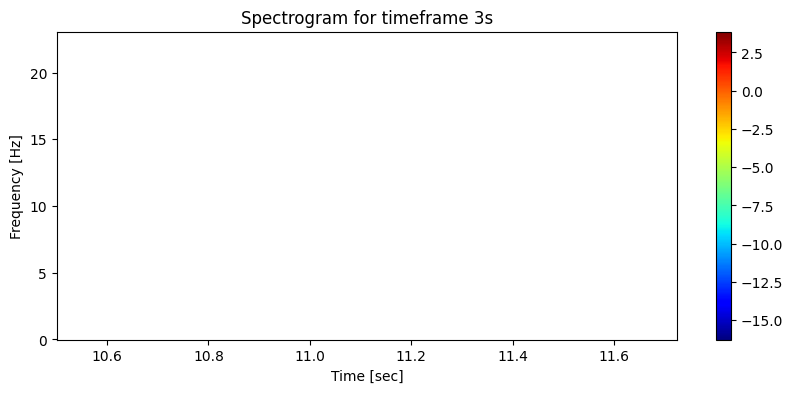

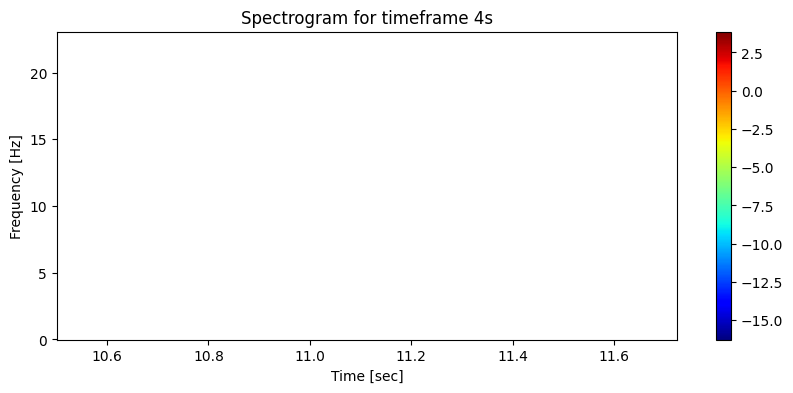

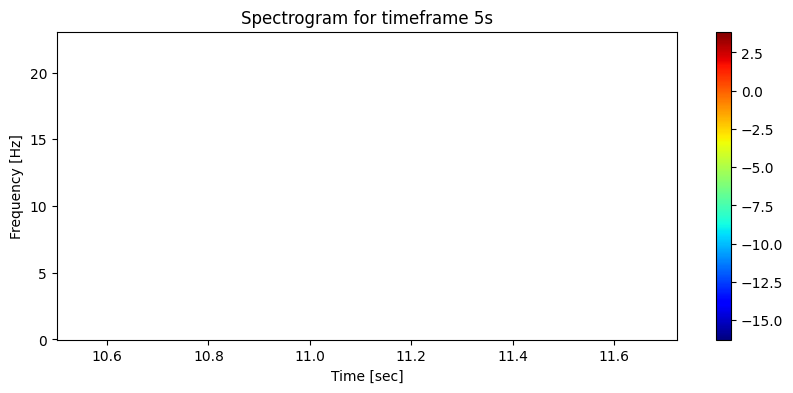

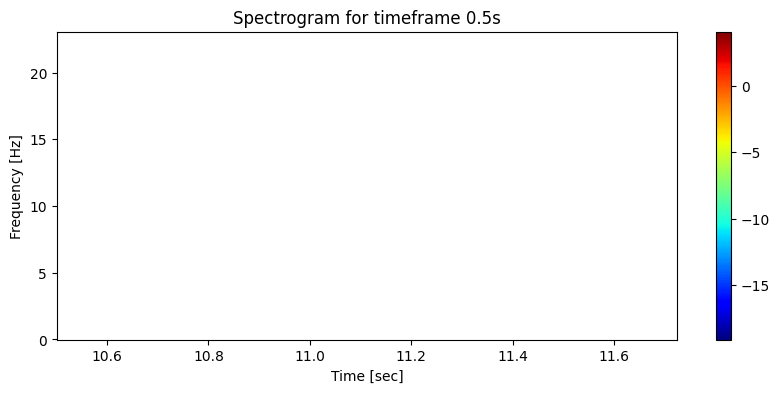

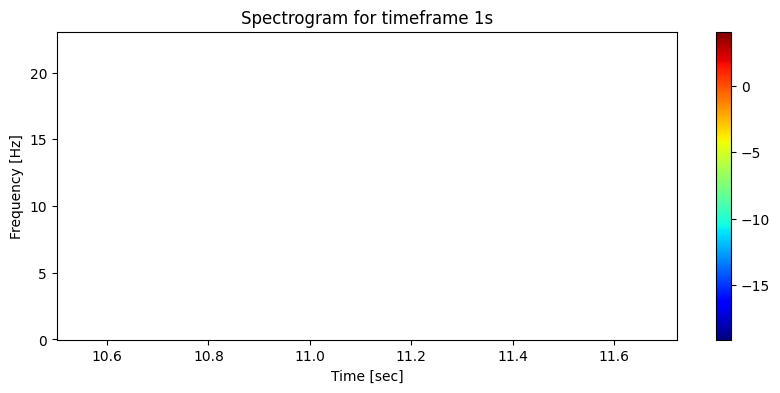

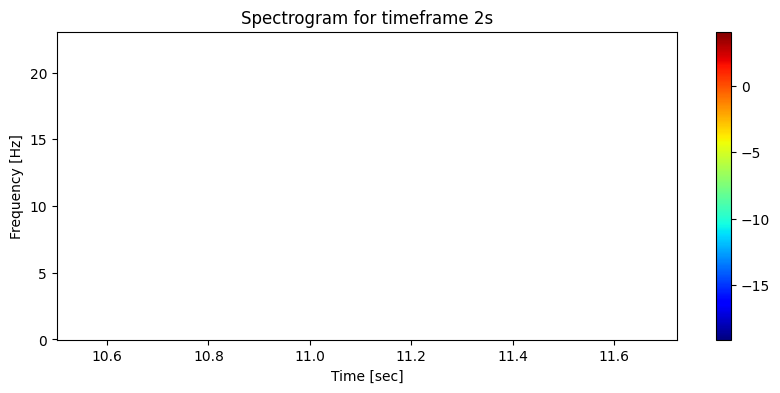

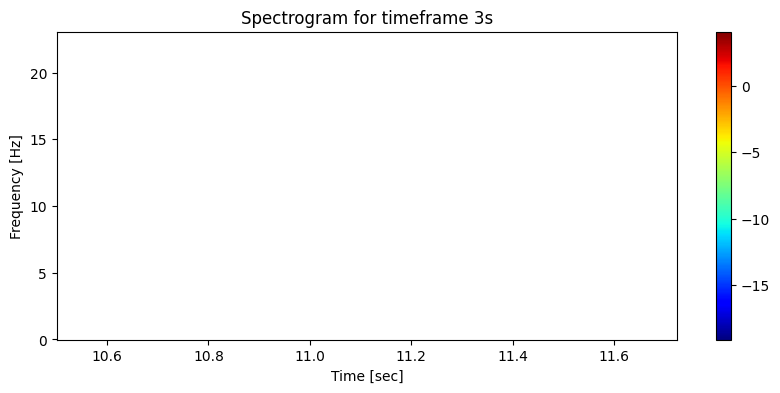

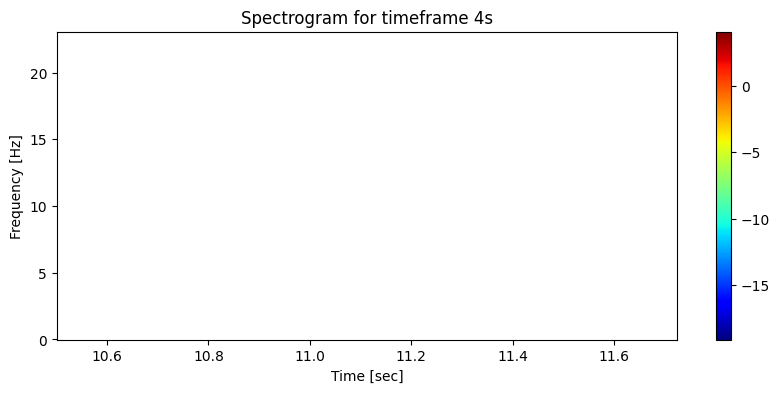

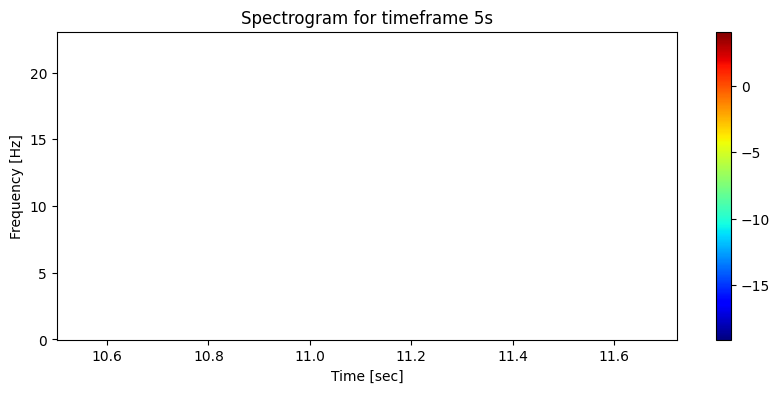

Subject 1, timeframe 0.5s: (513, 1)
Subject 1, timeframe 1s: (513, 1)
Subject 1, timeframe 2s: (513, 1)
Subject 1, timeframe 3s: (513, 1)
Subject 1, timeframe 4s: (513, 1)
Subject 1, timeframe 5s: (513, 1)
Subject 2, timeframe 0.5s: (513, 1)
Subject 2, timeframe 1s: (513, 1)
Subject 2, timeframe 2s: (513, 1)
Subject 2, timeframe 3s: (513, 1)
Subject 2, timeframe 4s: (513, 1)
Subject 2, timeframe 5s: (513, 1)
Subject 3, timeframe 0.5s: (513, 1)
Subject 3, timeframe 1s: (513, 1)
Subject 3, timeframe 2s: (513, 1)
Subject 3, timeframe 3s: (513, 1)
Subject 3, timeframe 4s: (513, 1)
Subject 3, timeframe 5s: (513, 1)
Subject 4, timeframe 0.5s: (513, 1)
Subject 4, timeframe 1s: (513, 1)
Subject 4, timeframe 2s: (513, 1)
Subject 4, timeframe 3s: (513, 1)
Subject 4, timeframe 4s: (513, 1)
Subject 4, timeframe 5s: (513, 1)


In [ ]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns

# Define the window size and overlap for the rolling window
window_size = 1024
overlap = window_size // 2

# Define the timeframes to use
timeframes = [0.5, 1, 2, 3, 4, 5]  # in seconds

# Assign the time values for each subject's index finger and thumb to x1, x2, x3, x4
x1 = gesturedata['time'][0]
x2 = gesturedata['time'][6]
x3 = gesturedata['time'][12]
x4 = gesturedata['time'][18]

# Assign the corresponding smooth data values for each subject's index finger and thumb to y1, y2, y3, y4
y1 = gesturedata['smooth_data'][0]
y2 = gesturedata['smooth_data'][6]
y3 = gesturedata['smooth_data'][12]
y4 = gesturedata['smooth_data'][18]

# Define a function to compute the spectrograms for a given timeframe
def compute_spectrogram(y, timeframe):
    # Compute the number of samples in the timeframe
    n_samples = int(timeframe / (x[1] - x[0]))
    # Compute the number of samples that overlap
    n_overlap = int(n_samples * 0.5)
    # Compute the spectrogram with the given parameters
    frequencies, times, spectrogram = signal.spectrogram(np.array(y), fs=1/(x[1]-x[0]), window='hann', nperseg=window_size, noverlap=overlap)

    plt.figure(figsize=(10, 4))
    plt.title(f"Spectrogram for timeframe {timeframe}s")
    plt.pcolormesh(times, frequencies, np.log(spectrogram), cmap='jet')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar()
    plt.show()

    return frequencies, times, spectrogram

# Compute the spectrograms for each timeframe and signal
spectrograms = []
for y in [y1, y2, y3, y4]:
    y_spectrograms = []
    for timeframe in timeframes:
        frequencies, times, spectrogram = compute_spectrogram(y, timeframe)
        y_spectrograms.append(spectrogram)
    spectrograms.append(np.array(y_spectrograms))

# Print the shape of the computed spectrograms
for i, y in enumerate([y1, y2, y3, y4]):
    for j, timeframe in enumerate(timeframes):
        print(f"Subject {i+1}, timeframe {timeframe}s: {spectrograms[i][j].shape}")

# TODO: Train the CNN on the spectrograms and compare the performance for different timeframes

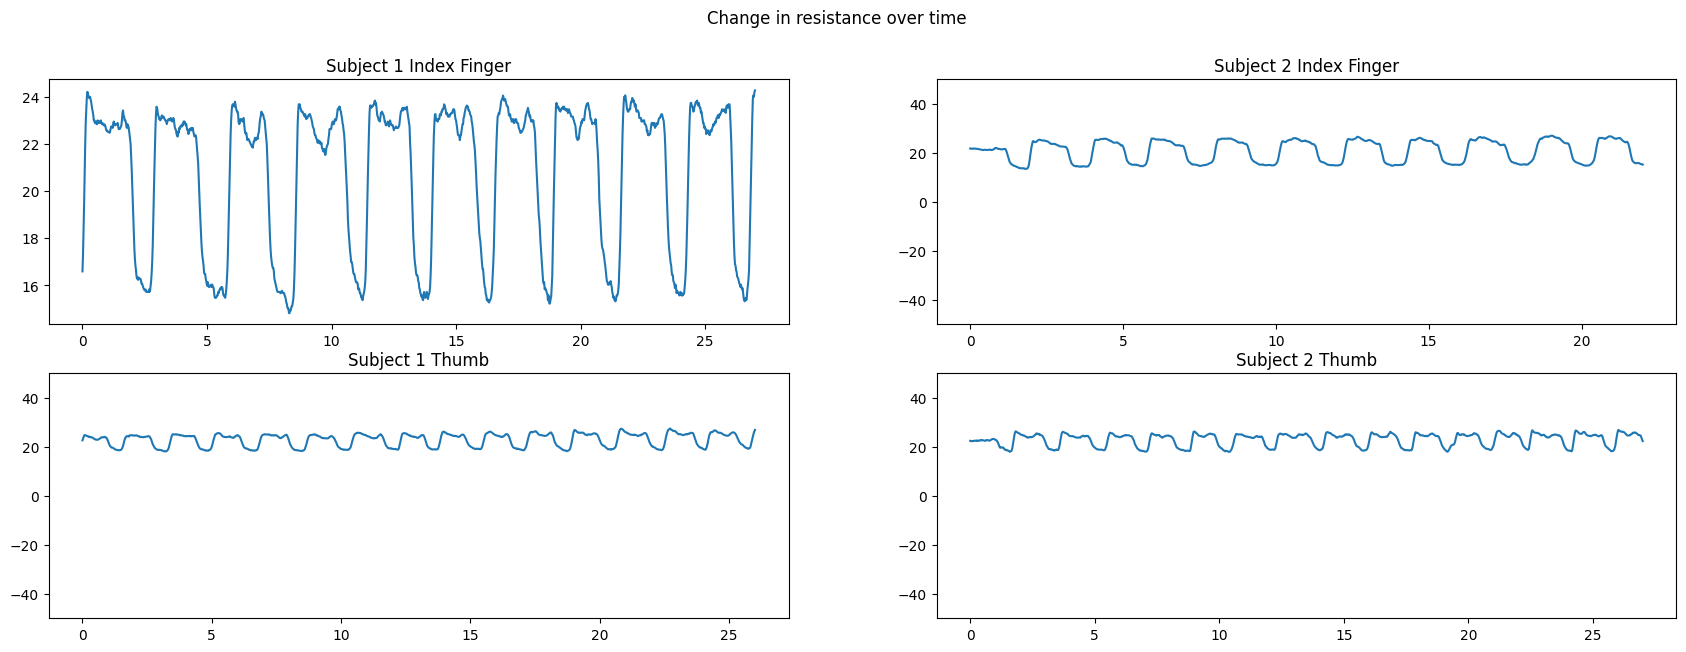

In [ ]:
# Assign the time values for each subject's index finger and thumb to x1, x2, x3, x4
x1 = gesturedata['time'][0]
x2 = gesturedata['time'][6]
x3 = gesturedata['time'][12]
x4 = gesturedata['time'][18]

# Assign the corresponding smooth data values for each subject's index finger and thumb to y1, y2, y3, y4
y1 = gesturedata['smooth_data'][0]
y2 = gesturedata['smooth_data'][6]
y3 = gesturedata['smooth_data'][12]
y4 = gesturedata['smooth_data'][18]

# Create a figure and four subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(21,7))

# Plot the first subplot using Seaborn's lineplot function
sns.lineplot(x=x1, y=y1, ax=axes[0, 0])
axes[0, 0].set_title('Subject 1 Index Finger')
#axes[0, 0].set_ylim(-50, 50)  # Set the y-axis limits

# Plot the second subplot using Seaborn's lineplot function
sns.lineplot(x=x2, y=y2, ax=axes[0, 1])
axes[0, 1].set_title('Subject 2 Index Finger')
axes[0, 1].set_ylim(-50, 50)  # Set the y-axis limits

# Plot the third subplot using Seaborn's lineplot function
sns.lineplot(x=x3, y=y3, ax=axes[1, 0])
axes[1, 0].set_title('Subject 1 Thumb')
axes[1, 0].set_ylim(-50, 50)  # Set the y-axis limits

# Plot the fourth subplot using Seaborn's lineplot function
sns.lineplot(x=x4, y=y4, ax=axes[1, 1])
axes[1, 1].set_title('Subject 2 Thumb')
axes[1, 1].set_ylim(-50, 50)  # Set the y-axis limits

# Add a title to the figure
fig.suptitle('Change in resistance over time')

# Show the figure
plt.show()



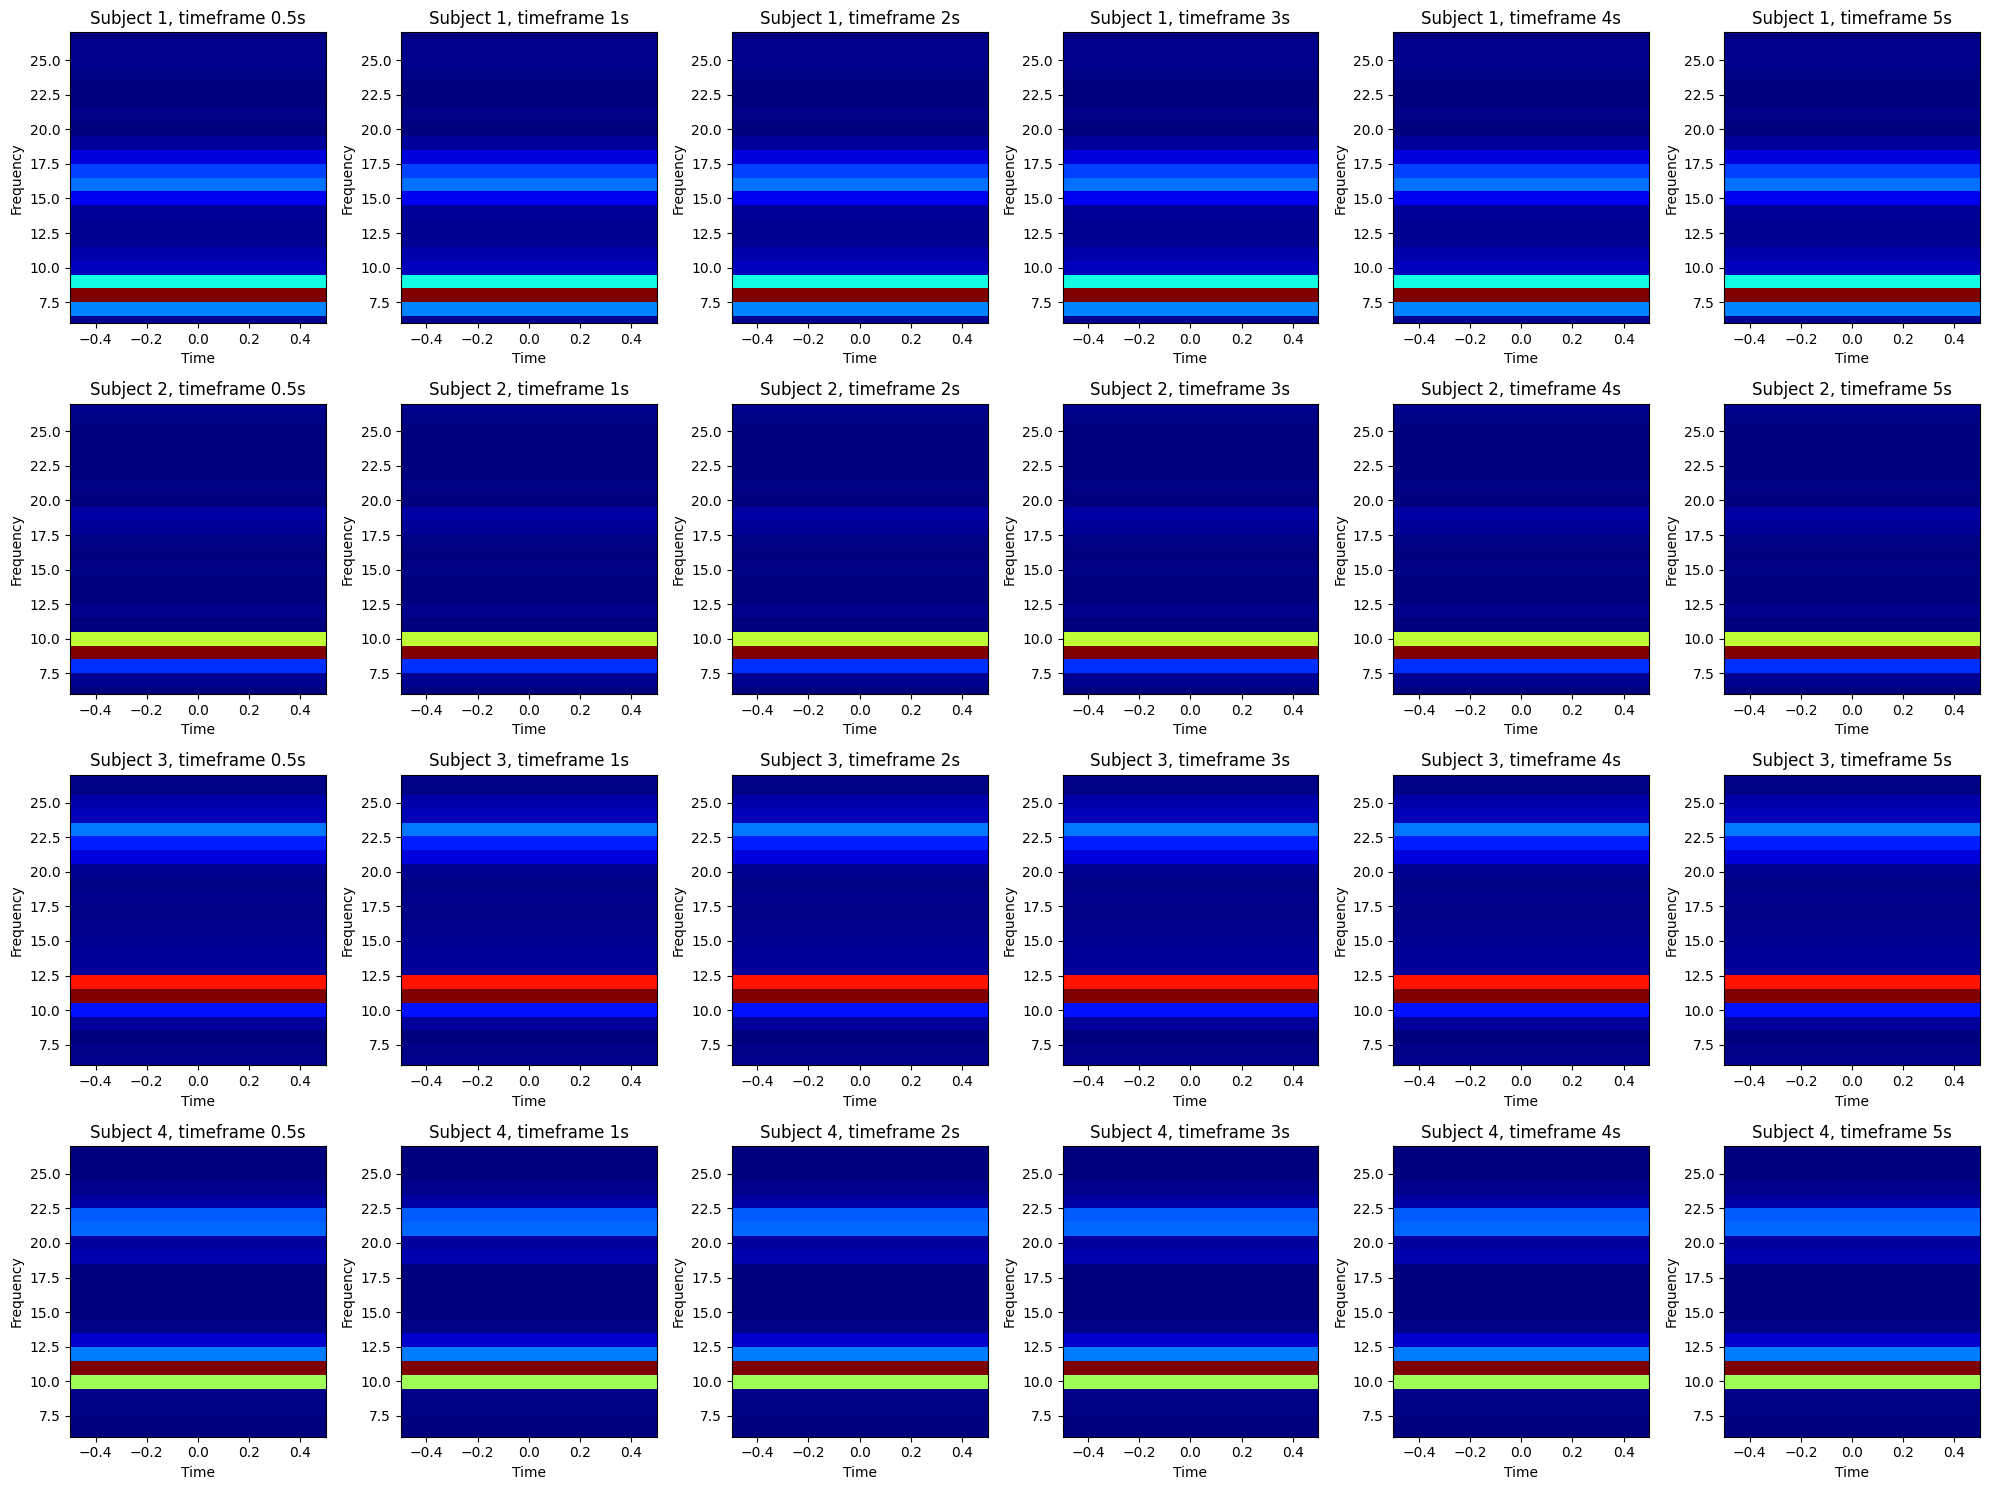

In [ ]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns

# Define the window size and overlap for the rolling window
window_size = 1024
overlap = window_size // 2

# Define the timeframes to use
timeframes = [0.5, 1, 2, 3, 4, 5]  # in seconds

# Assign the time values for each subject's index finger and thumb to x1, x2, x3, x4
x1 = gesturedata['time'][0]
x2 = gesturedata['time'][6]
x3 = gesturedata['time'][12]
x4 = gesturedata['time'][18]

# Assign the corresponding smooth data values for each subject's index finger and thumb to y1, y2, y3, y4
y1 = gesturedata['smooth_data'][0]
y2 = gesturedata['smooth_data'][6]
y3 = gesturedata['smooth_data'][12]
y4 = gesturedata['smooth_data'][18]

# Define a function to compute the spectrograms for a given timeframe
def compute_spectrogram(y, timeframe):
    # Compute the number of samples in the timeframe
    n_samples = int(timeframe / (x1[1] - x1[0]))
    # Compute the number of samples that overlap
    n_overlap = int(n_samples * 0.5)
    # Compute the spectrogram with the given parameters
    frequencies, times, spectrogram = signal.spectrogram(np.array(y), fs=1/(x1[1]-x1[0]), window='hann', nperseg=window_size, noverlap=overlap)
    return frequencies, times, spectrogram

# Compute the spectrograms for each timeframe and signal
spectrograms = []
for y in [y1, y2, y3, y4]:
    y_spectrograms = []
    for timeframe in timeframes:
        frequencies, times, spectrogram = compute_spectrogram(y, timeframe)
        y_spectrograms.append(spectrogram)
    spectrograms.append(np.array(y_spectrograms))

# Plot the computed spectrograms
fig, axes = plt.subplots(nrows=4, ncols=len(timeframes), figsize=(20, 15))

for i in range(4):
    for j in range(len(timeframes)):
        axes[i, j].imshow(spectrograms[i][j], origin='lower', cmap='jet', aspect='auto')
        axes[i, j].set_xlabel('Time')
        axes[i, j].set_ylabel('Frequency')
        #axes[i, j].set_ylim([0, 50])
        axes[i, j].set_ylim([6, 27])
        axes[i, j].set_title(f"Subject {i+1}, timeframe {timeframes[j]}s")

plt.tight_layout()
plt.show()

#Spectrogram - (final) trail 3

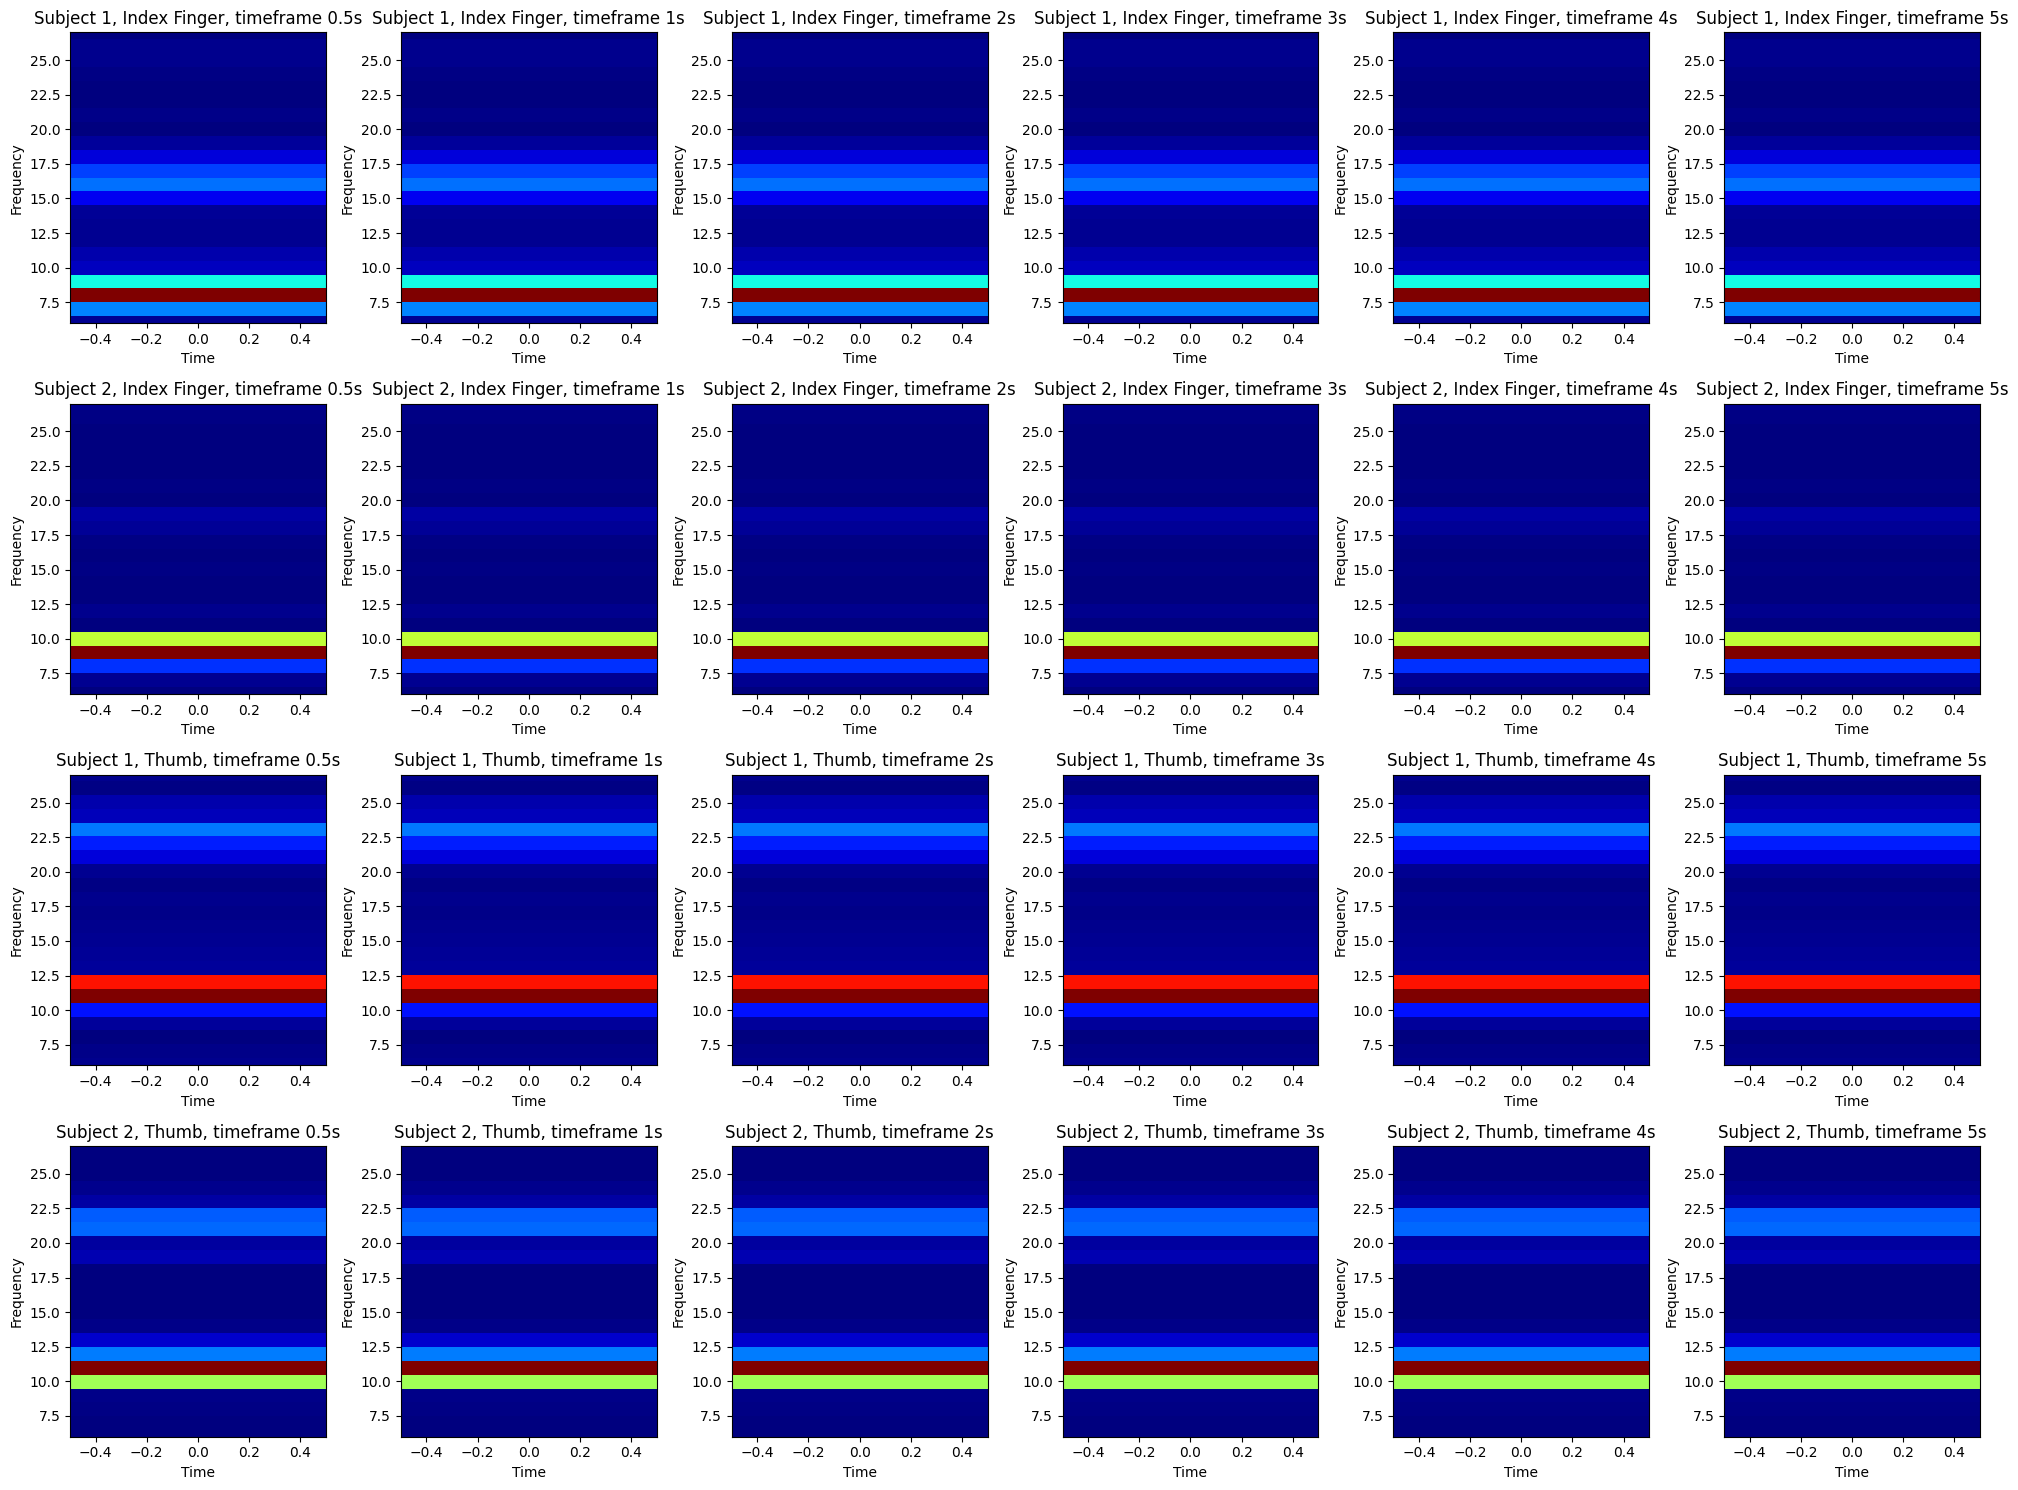

In [ ]:
# Define the window size and overlap for the rolling window
window_size = 1024
overlap = window_size // 2

# Define the timeframes to use
timeframes = [0.5, 1, 2, 3, 4, 5]  # in seconds

# Assign the time values for each subject's index finger and thumb to x1, x2, x3, x4
x1 = gesturedata['time'][0]
x2 = gesturedata['time'][6]
x3 = gesturedata['time'][12]
x4 = gesturedata['time'][18]

# Assign the corresponding smooth data values for each subject's index finger and thumb to y1, y2, y3, y4
y1 = gesturedata['smooth_data'][0]
y2 = gesturedata['smooth_data'][6]
y3 = gesturedata['smooth_data'][12]
y4 = gesturedata['smooth_data'][18]

# Define a function to compute the spectrograms for a given timeframe
def compute_spectrogram(y, timeframe):
    # Compute the number of samples in the timeframe
    n_samples = int(timeframe / (x1[1] - x1[0]))
    # Compute the number of samples that overlap
    n_overlap = int(n_samples * 0.5)
    # Compute the spectrogram with the given parameters
    frequencies, times, spectrogram = signal.spectrogram(np.array(y), fs=1/(x1[1]-x1[0]), window='hann', nperseg=window_size, noverlap=overlap)
    return frequencies, times, spectrogram

# Compute the spectrograms for each timeframe and signal
spectrograms = []
for y, finger_name in zip([y1, y2, y3, y4], ['Subject 1, Index Finger', 'Subject 2, Index Finger', 'Subject 1, Thumb', 'Subject 2, Thumb']):
    y_spectrograms = []
    for timeframe in timeframes:
        frequencies, times, spectrogram = compute_spectrogram(y, timeframe)
        y_spectrograms.append(spectrogram)
    spectrograms.append(np.array(y_spectrograms))

# Plot the computed spectrograms
fig, axes = plt.subplots(nrows=4, ncols=len(timeframes), figsize=(20, 15))

for i, finger_name in enumerate(['Subject 1, Index Finger', 'Subject 2, Index Finger', 'Subject 1, Thumb', 'Subject 2, Thumb']):
    for j in range(len(timeframes)):
        axes[i, j].imshow(spectrograms[i][j], origin='lower', cmap='jet', aspect='auto')
        axes[i, j].set_xlabel('Time')
        axes[i, j].set_ylabel('Frequency')
        axes[i, j].set_ylim([6, 27])
        axes[i, j].set_title(f"{finger_name}, timeframe {timeframes[j]}s")

plt.tight_layout()
plt.show()


#Spectrogram - trail 4

<ipython-input-28-acc9626bcf7d>:45: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axes[i, j].imshow(spectrograms[i][j], origin='lower', cmap='jet', aspect='auto', extent=[times_rolling[0], times_rolling[-1], frequencies[0], frequencies[-1]])


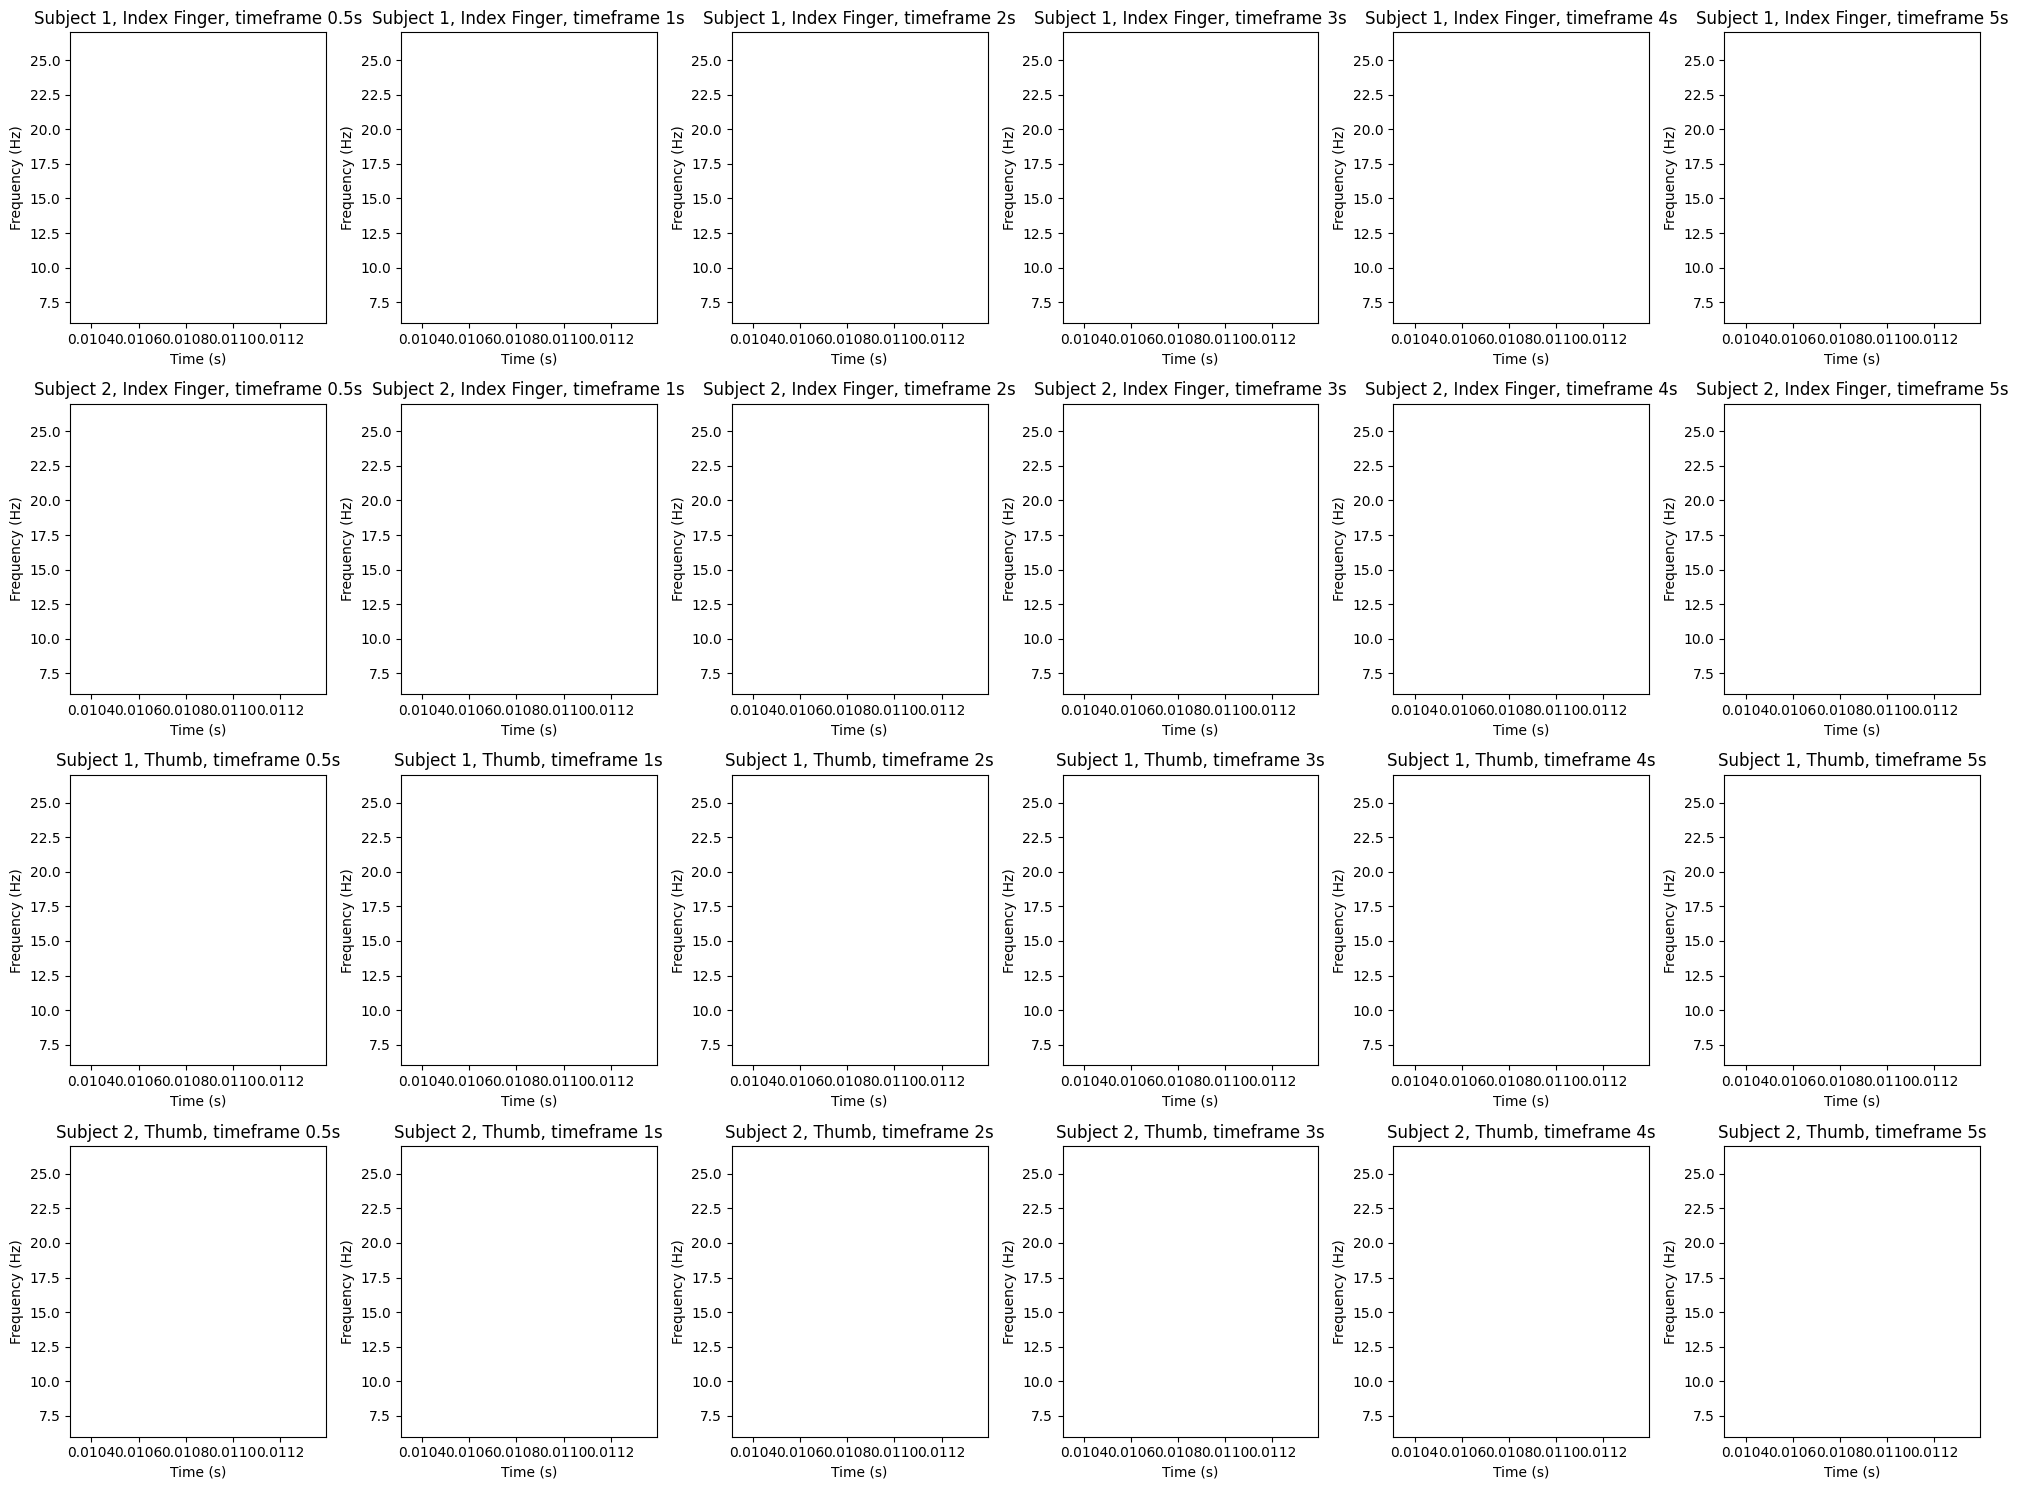

In [ ]:
# Define the window size and overlap for the rolling window
window_size = 1024
overlap = window_size // 2

# Define the timeframes to use
timeframes = [0.5, 1, 2, 3, 4, 5]  # in seconds

# Assign the time values for each subject's index finger and thumb to x1, x2, x3, x4
x1 = gesturedata['time'][0]
x2 = gesturedata['time'][6]
x3 = gesturedata['time'][12]
x4 = gesturedata['time'][18]

# Assign the corresponding smooth data values for each subject's index finger and thumb to y1, y2, y3, y4
y1 = gesturedata['smooth_data'][0]
y2 = gesturedata['smooth_data'][6]
y3 = gesturedata['smooth_data'][12]
y4 = gesturedata['smooth_data'][18]

# Define a function to compute the spectrograms for a given timeframe
def compute_spectrogram(y, timeframe):
    # Compute the number of samples in the timeframe
    n_samples = int(timeframe / (x1[1] - x1[0]))
    # Compute the number of samples that overlap
    n_overlap = int(n_samples * 0.5)
    # Compute the spectrogram with the given parameters
    frequencies, times, spectrogram = signal.spectrogram(np.array(y), fs=1/(x1[1]-x1[0]), window='hann', nperseg=window_size, noverlap=n_overlap)
    return frequencies, times, spectrogram

# Compute the spectrograms for each timeframe and signal
spectrograms = []
for y, finger_name in zip([y1, y2, y3, y4], ['Subject 1, Index Finger', 'Subject 2, Index Finger', 'Subject 1, Thumb', 'Subject 2, Thumb']):
    y_spectrograms = []
    for timeframe in timeframes:
        _, times, spectrogram = compute_spectrogram(y, timeframe)
        y_spectrograms.append(spectrogram)
    spectrograms.append(np.array(y_spectrograms))

# Plot the computed spectrograms
fig, axes = plt.subplots(nrows=4, ncols=len(timeframes), figsize=(20, 15))

for i, finger_name in enumerate(['Subject 1, Index Finger', 'Subject 2, Index Finger', 'Subject 1, Thumb', 'Subject 2, Thumb']):
    for j in range(len(timeframes)):
        times_rolling = np.convolve(times, np.ones((window_size,))/window_size, mode='valid')
        axes[i, j].imshow(spectrograms[i][j], origin='lower', cmap='jet', aspect='auto', extent=[times_rolling[0], times_rolling[-1], frequencies[0], frequencies[-1]])
        #axes[i, j].set_xlim([times.min()-1, times.max()+1])
        axes[i, j].set_xlabel('Time (s)')
        axes[i, j].set_ylabel('Frequency (Hz)')
        axes[i, j].set_ylim([6, 27])
        axes[i, j].set_title(f"{finger_name}, timeframe {timeframes[j]}s")




plt.tight_layout()
plt.show()

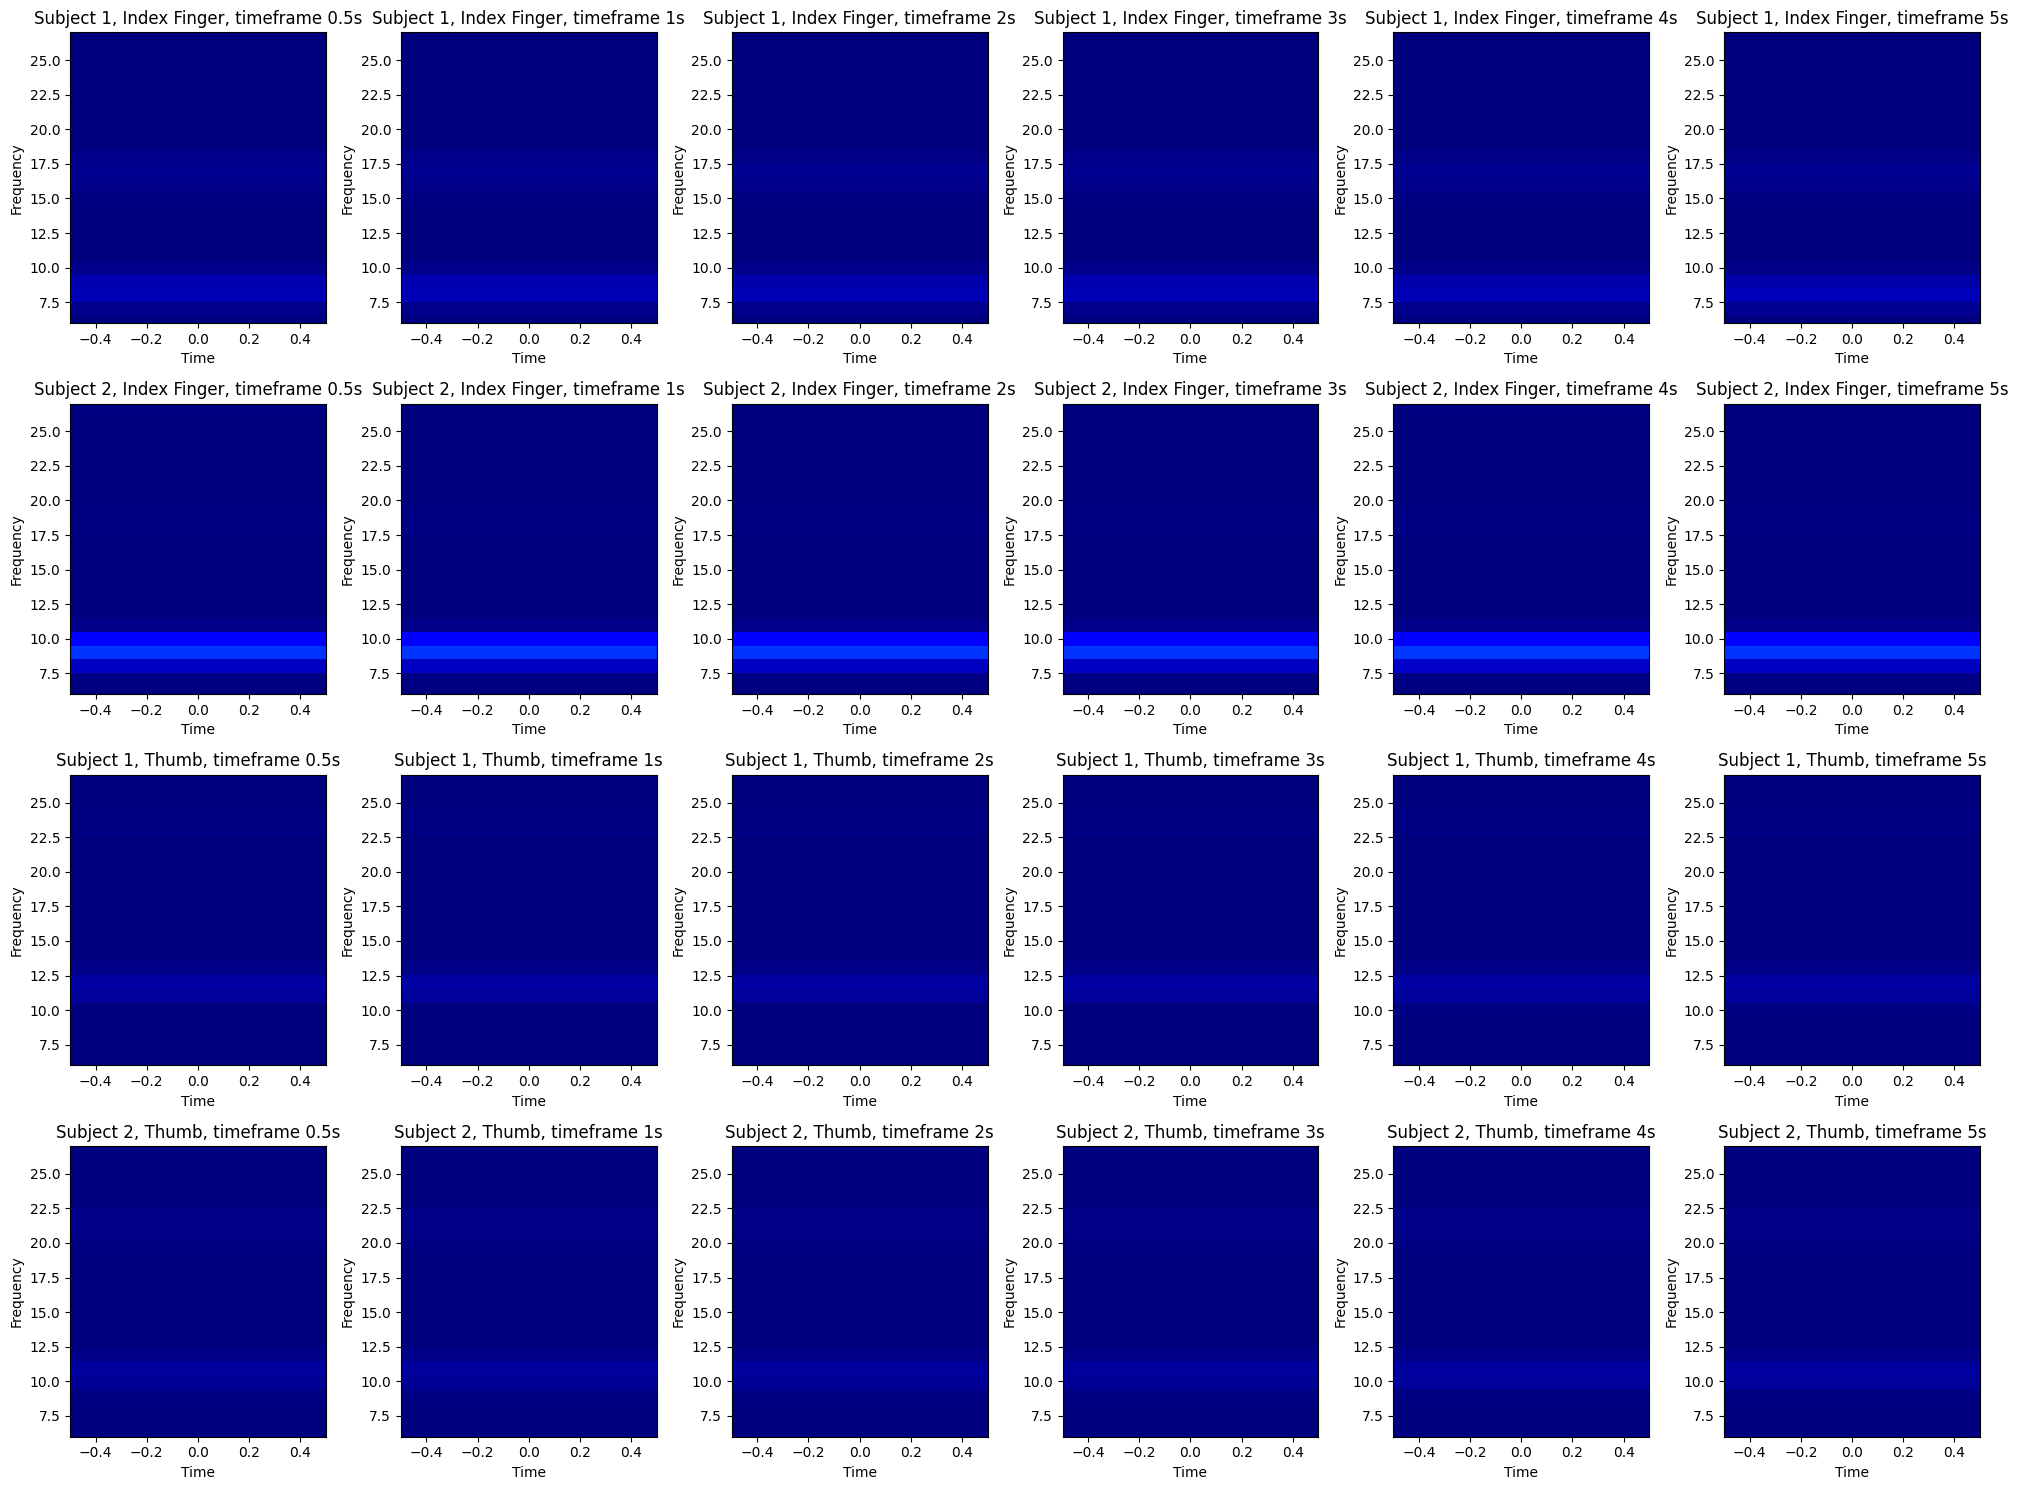

In [ ]:
# Define the window size and overlap for the rolling window
window_size = 1024
overlap = window_size // 2

# Define the timeframes to use
timeframes = [0.5, 1, 2, 3, 4, 5]  # in seconds

# Assign the time values for each subject's index finger and thumb to x1, x2, x3, x4
x1 = gesturedata['time'][0]
x2 = gesturedata['time'][6]
x3 = gesturedata['time'][12]
x4 = gesturedata['time'][18]

# Assign the corresponding smooth data values for each subject's index finger and thumb to y1, y2, y3, y4
y1 = gesturedata['smooth_data'][0]
y2 = gesturedata['smooth_data'][6]
y3 = gesturedata['smooth_data'][12]
y4 = gesturedata['smooth_data'][18]

# Define a function to compute the spectrograms for a given timeframe using rolling windows
def compute_rolling_spectrogram(y, timeframe):
    # Compute the number of samples in the timeframe
    n_samples = int(timeframe / (x1[1] - x1[0]))
    # Create the rolling window with 50% overlap
    window = signal.windows.hann(window_size)
    step = int(n_samples / 2)
    n_windows = int((len(y) - window_size) / step) + 1
    # Compute the spectrogram for each rolling window
    spectrograms = []
    for i in range(n_windows):
        start = i * step
        end = start + window_size
        windowed_signal = y[start:end] * window
        _, _, Sxx = signal.spectrogram(windowed_signal, fs=1/(x1[1]-x1[0]), window='hann', nperseg=window_size, noverlap=overlap)
        # Calculate the start time of the current window
        t_start = i * step * (x1[1] - x1[0])
        # Adjust the time axis to start at 0
        t = np.linspace(0, timeframe, len(Sxx[0]))
        # Subtract the start time of the first window from all time values
        t -= t_start
        spectrograms.append(Sxx)
    return np.mean(spectrograms, axis=0)

# Compute the spectrograms for each timeframe and signal using rolling windows
spectrograms = []
for y, finger_name in zip([y1, y2, y3, y4], ['Subject 1, Index Finger', 'Subject 2, Index Finger', 'Subject 1, Thumb', 'Subject 2, Thumb']):
    y_spectrograms = []
    for timeframe in timeframes:
        spectrogram = compute_rolling_spectrogram(y, timeframe)
        y_spectrograms.append(spectrogram)
    spectrograms.append(np.array(y_spectrograms))

# Plot the computed spectrograms
fig, axes = plt.subplots(nrows=4, ncols=len(timeframes), figsize=(20, 15))

for i, finger_name in enumerate(['Subject 1, Index Finger', 'Subject 2, Index Finger', 'Subject 1, Thumb', 'Subject 2, Thumb']):
    for j in range(len(timeframes)):
        axes[i, j].imshow(spectrograms[i][j], origin='lower', cmap='jet', aspect='auto')
        axes[i, j].set_xlabel('Time')
        axes[i, j].set_ylabel('Frequency')
        axes[i, j].set_ylim([6, 27])
        axes[i, j].set_title(f"{finger_name}, timeframe {timeframes[j]}s")

plt.tight_layout()
plt.show()



#Spectrogram - final

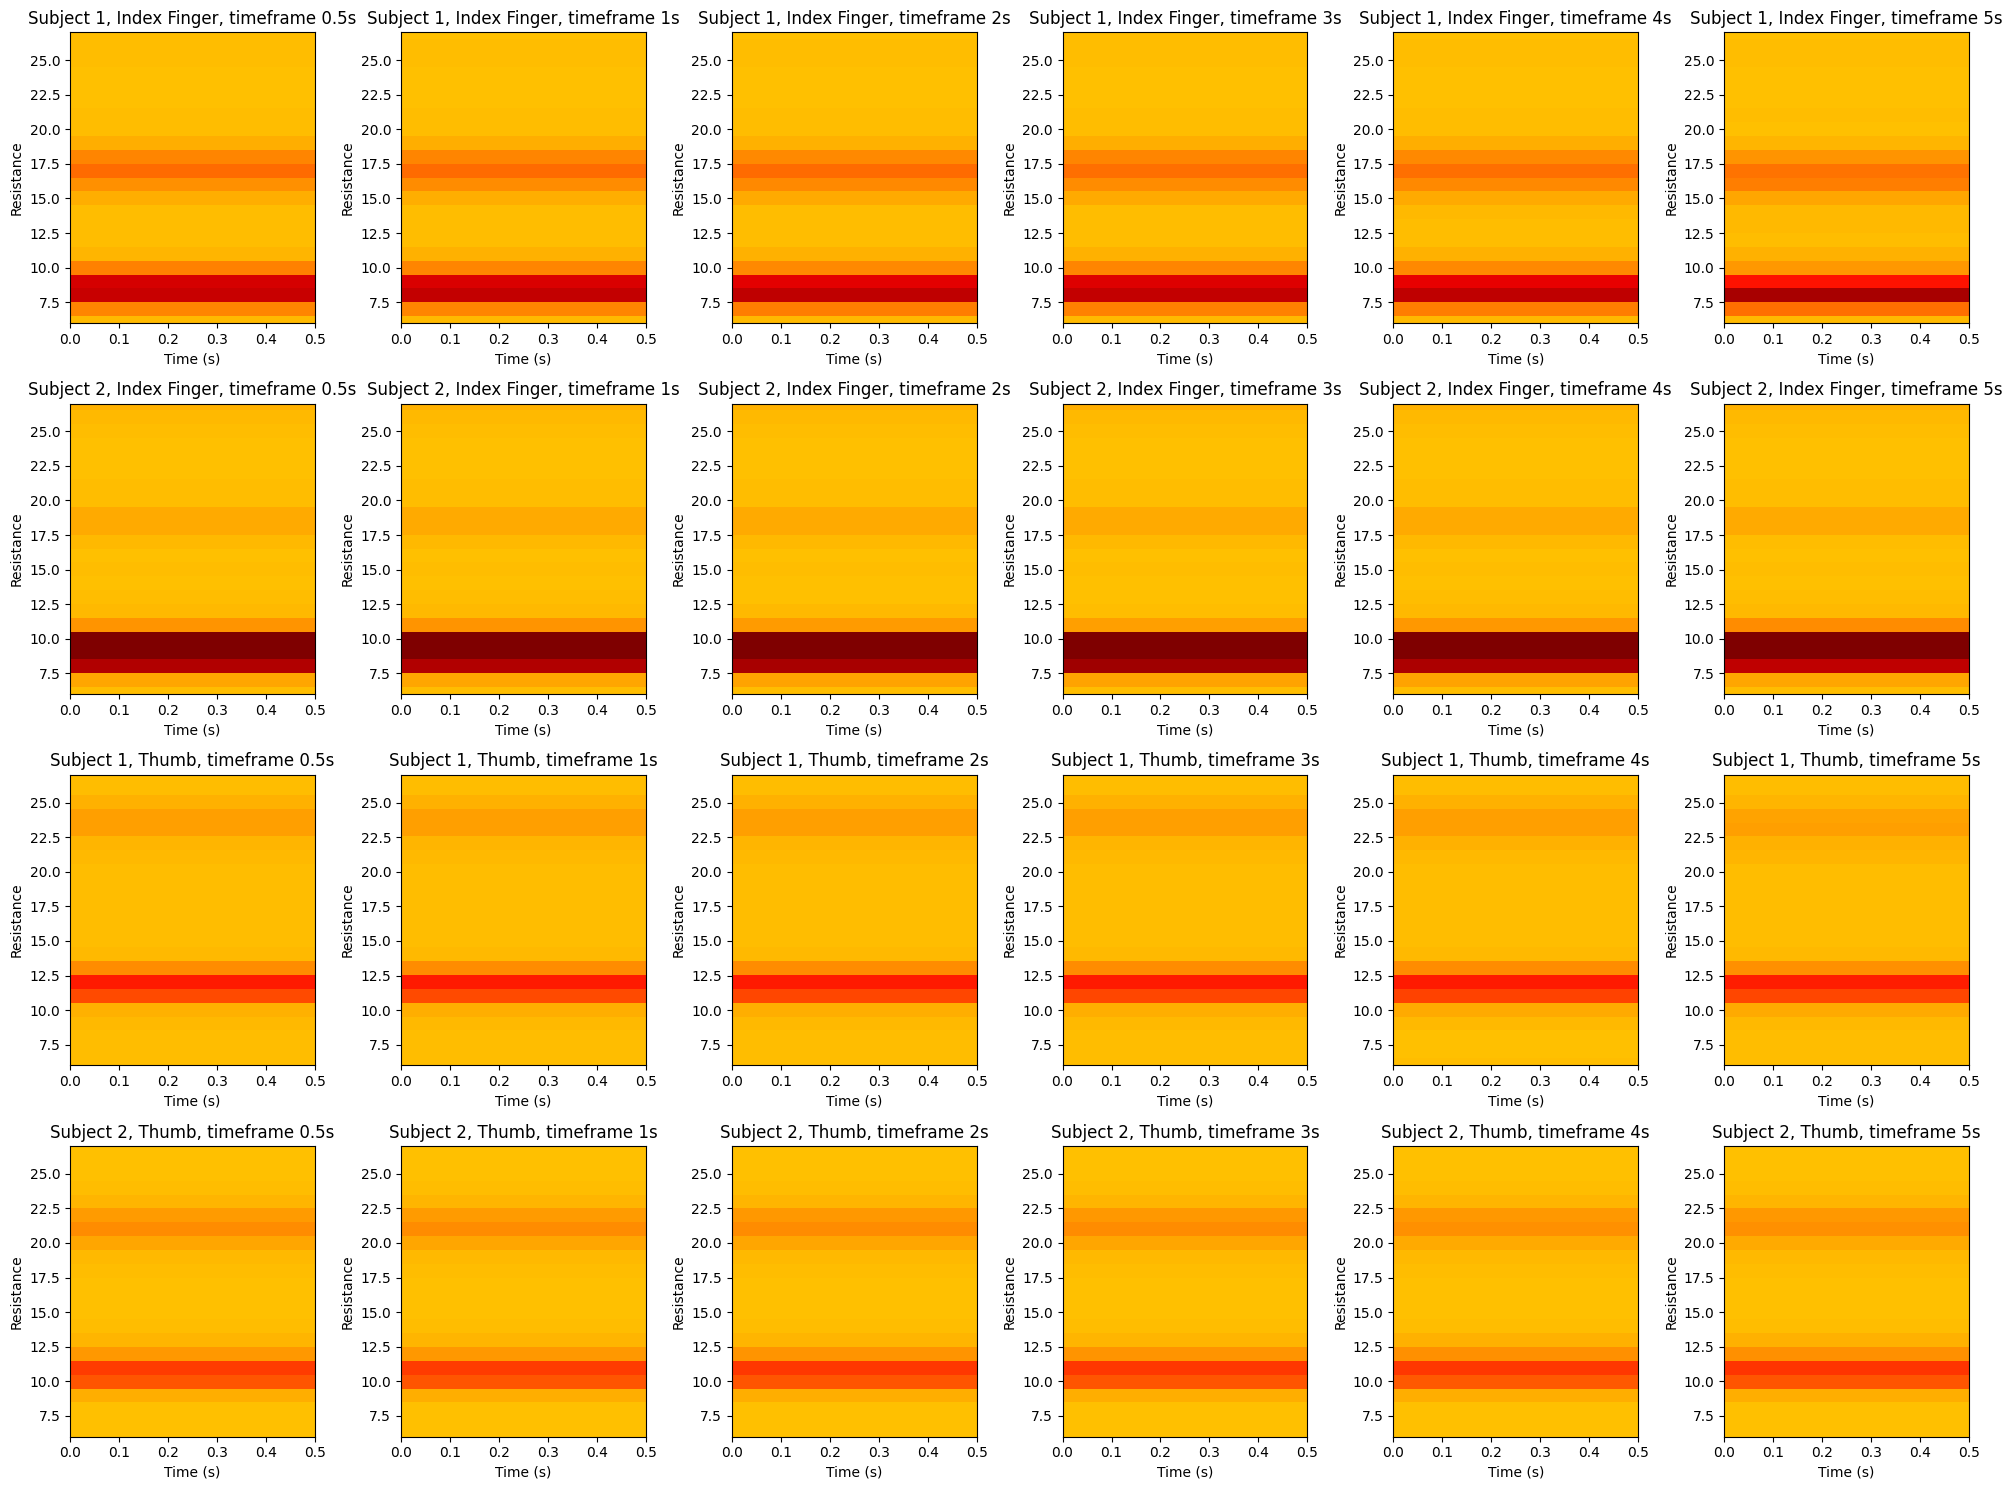

In [ ]:
# Assign the time values for each subject's index finger and thumb to x1, x2, x3, x4
x1 = gesturedata['time'][0]
x2 = gesturedata['time'][6]
x3 = gesturedata['time'][12]
x4 = gesturedata['time'][18]

# Convert each x variable to a numpy array
x1 = np.array(x1)
x2 = np.array(x2)
x3 = np.array(x3)
x4 = np.array(x4)

# Subtract the minimum time value from all the time arrays
x1 -= x1.min()
x2 -= x2.min()
x3 -= x3.min()
x4 -= x4.min()

# Assign the corresponding smooth data values for each subject's index finger and thumb to y1, y2, y3, y4
y1 = gesturedata['smooth_data'][0]
y2 = gesturedata['smooth_data'][6]
y3 = gesturedata['smooth_data'][12]
y4 = gesturedata['smooth_data'][18]

# Define a function to compute the spectrograms for a given timeframe using rolling windows
def compute_rolling_spectrogram(y, timeframe, x):
    # Subtract the minimum time value from the time array
    x = x - x.min()
    # Compute the number of samples in the timeframe
    n_samples = int(timeframe / (x[1] - x[0]))
    # Create the rolling window with 50% overlap
    window = signal.windows.hann(window_size)
    step = int(n_samples / 2)
    n_windows = int((len(y) - window_size) / step) + 1
    # Compute the spectrogram for each rolling window
    spectrograms = []
    for i in range(n_windows):
        start = i * step
        end = start + window_size
        windowed_signal = y[start:end] * window
        _, _, Sxx = signal.spectrogram(windowed_signal, fs=1/(x[1]-x[0]), window='hann', nperseg=window_size, noverlap=overlap)
        spectrograms.append(Sxx)
    return np.mean(spectrograms, axis=0)

# Compute the spectrograms for each timeframe and signal using rolling windows
spectrograms = []
for y, x, finger_name in zip([y1, y2, y3, y4], [x1, x2, x3, x4], ['Subject 1, Index Finger', 'Subject 2, Index Finger', 'Subject 1, Thumb', 'Subject 2, Thumb']):
    y_spectrograms = []
    for timeframe in timeframes:
        spectrogram = compute_rolling_spectrogram(y, timeframe, x)
        y_spectrograms.append(spectrogram)
    spectrograms.append(np.array(y_spectrograms))

# Plot the computed spectrograms
fig, axes = plt.subplots(nrows=4, ncols=len(timeframes), figsize=(20, 15))

# set vmin and vmax for the color scale
#vmin = -50 150 200 120
#vmax = 50 50 100 50
vmin = -120
vmax = 50

for i, finger_name in enumerate(['Subject 1, Index Finger', 'Subject 2, Index Finger', 'Subject 1, Thumb', 'Subject 2, Thumb']):
    for j in range(len(timeframes)):
        im = axes[i, j].imshow(spectrograms[i][j], origin='lower', cmap='jet', aspect='auto', vmin=vmin, vmax=vmax)
        #im = axes[i, j].imshow(spectrograms[i][j], origin='lower', cmap='jet', aspect='auto')
        axes[i, j].set_xlabel('Time (s)')
        axes[i, j].set_ylabel('Resistance')
        axes[i, j].set_ylim([6, 27])
        axes[i, j].set_title(f"{finger_name}, timeframe {timeframes[j]}s")
        axes[i, j].set_xlim(left=0)

#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#cbar = fig.colorbar(im, cax=cbar_ax)
#cbar.set_label('Power Spectral Density (dB/Hz)')
plt.tight_layout()
plt.show()



#KNN

In [ ]:
gesturedata = gesturedata.drop([22])
gesturedata = gesturedata.reset_index(drop=True)

In [ ]:
# Define the label values as a list
label_values = ['index', 'index', 'index', 'index', 'index', 'index', 'index', 'index', 'index', 'index', 'index', 'thumb', 'thumb', 'thumb', 'thumb', 'thumb', 'thumb', 'thumb', 'thumb', 'thumb', 'thumb', 'thumb']

# Add a new column to the DataFrame and assign the label values to it
gesturedata['labels'] = label_values

In [ ]:
gesturedata

,_id,labels,start_time,end_time,data,smooth_data,time,min,max,mean,variance,std,skew,zero_crossings,peaks,valleys
0,642cba40f6318311604d2a1b,index,0,27,"[16.22950745, 15.16854, 16.58461571, 15.875127...","[16.59, 17.31, 18.34, 19.43, 20.73, 21.92, 22....","[0.0, 0.021704180064308683, 0.0434083601286173...",14.114053,24.957985,20.808872,10.374952,3.221017,-0.733337,0,151,151
1,642cba8cf6318311604d2a1c,index,0,27,"[20.53941917, 20.53941917, 22.73486519, 21.268...","[21.22, 21.37, 21.43, 21.11, 21.06, 20.96, 21....","[0.0, 0.019522776572668113, 0.0390455531453362...",14.464830,26.080084,21.670799,11.747311,3.427435,-0.780636,0,133,133
2,642cbad6f6318311604d2a1d,index,0,24,"[21.26819229, 20.53941917, 20.53941917, 20.903...","[20.64, 20.64, 20.7, 20.7, 20.75, 20.75, 20.8,...","[0.0, 0.01937046004842615, 0.0387409200968523,...",14.114053,27.966103,22.424759,14.090221,3.753694,-0.762733,0,117,116
3,642cbb03f6318311604d2a1e,index,0,23,"[22, 22.36705017, 22.36705017, 22, 22.36705017...","[22.05, 22.0, 22.0, 21.84, 21.9, 21.84, 21.9, ...","[0.0, 0.020087336244541485, 0.0401746724890829...",14.464830,29.872206,23.195831,17.216517,4.149279,-0.676597,0,111,112
4,642cbb38f6318311604d2a1f,index,0,27,"[26.83210182, 26.45569611, 26.83210182, 25.705...","[26.19, 26.08, 25.97, 25.87, 25.87, 25.76, 25....","[0.0, 0.018633540372670808, 0.0372670807453416...",15.168540,30.640343,24.339691,19.373958,4.401586,-0.763852,0,142,142
5,642cbc8bf6318311604d2a20,index,0,25,"[20.90342712, 21.26819229, 20.17616653, 20.903...","[20.75, 20.75, 20.75, 20.85, 20.8, 20.7, 20.8,...","[0.0, 0.01893939393939394, 0.03787878787878788...",13.065989,27.587299,21.359893,20.221921,4.496879,-0.400762,0,131,130
6,642cbcc2f6318311604d2a21,index,0,22,"[22.36705017, 21.63371468, 22, 21.26819229, 22...","[21.74, 21.63, 21.69, 21.69, 21.69, 21.58, 21....","[0.0, 0.018949181739879414, 0.0378983634797588...",13.065989,27.587299,20.782574,20.871580,4.568542,-0.237188,0,111,111
7,642cbd02f6318311604d2a22,index,0,23,"[23.10344887, 23.10344887, 23.10344887, 23.103...","[23.05, 23.05, 23.1, 23.1, 23.05, 23.1, 23.1, ...","[0.0, 0.019246861924686193, 0.0384937238493723...",14.816326,28.726116,22.126012,21.495863,4.636363,-0.348626,0,98,98
8,642cbd28f6318311604d2a23,index,0,25,"[24.21383667, 24.21383667, 23.84293175, 24.213...","[24.43, 24.53, 24.59, 24.8, 24.85, 24.85, 24.9...","[0.0, 0.01849112426035503, 0.03698224852071006...",15.168540,30.255861,23.135769,23.815033,4.880065,-0.471552,0,106,105
9,642cbd4bf6318311604d2a24,index,0,24,"[22, 22.36705017, 22.36705017, 22, 22.73486519...","[22.26, 22.31, 22.31, 22.26, 22.26, 22.16, 22....","[0.0, 0.018867924528301886, 0.0377358490566037...",14.114053,29.872206,22.363672,24.896618,4.989651,-0.351576,0,87,86


In [ ]:
from sklearn.model_selection import train_test_split
# Split data into training and testing sets
#from sklearn.model_selection import train_test_split
#X = gesturedata[['min', 'max', 'mean', 'variance', 'std', 'skew']] # Features
#y = gesturedata['labels'] # Labels
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split data based on labels
thumb_data = gesturedata[gesturedata['labels'] == 'thumb']
index_data = gesturedata[gesturedata['labels'] == 'index']

# Split thumb data into training and testing sets
X_train_thumb, X_test_thumb, y_train_thumb, y_test_thumb = train_test_split(thumb_data[['min', 'max', 'mean', 'variance', 'std', 'skew']], thumb_data['labels'], test_size=0.5, random_state=42)

# Split index data into training and testing sets
X_train_index, X_test_index, y_train_index, y_test_index = train_test_split(index_data[['min', 'max', 'mean', 'variance', 'std', 'skew']], index_data['labels'], test_size=0.5, random_state=42)

# Combine the training and testing sets for both labels
X_train = pd.concat([X_train_thumb, X_train_index])
X_test = pd.concat([X_test_thumb, X_test_index])
y_train = pd.concat([y_train_thumb, y_train_index])
y_test = pd.concat([y_test_thumb, y_test_index])

# Normalize data using min-max scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train KNN model
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)

# Evaluate KNN model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = knn.predict(X_test_scaled)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='weighted'))
print('Recall:', recall_score(y_test, y_pred, average='weighted'))
print('F1 score:', f1_score(y_test, y_pred, average='weighted'))

print(y_train.value_counts())
print(y_test.value_counts())


Accuracy: 0.8333333333333334
Precision: 0.875
Recall: 0.8333333333333334
F1 score: 0.8285714285714286
thumb    5
index    5
Name: labels, dtype: int64
thumb    6
index    6
Name: labels, dtype: int64


In [ ]:
# Assume X is a numpy array of the new input features
#X = np.array([14.464830,	26.080084,	21.670799,	11.747311,	3.427435,	-0.780636])
#X = np.array([19.813663,	36.905537,	27.511567,	13.116044,	3.621608,	-0.387926])

#the below is index finger data, but classifying as thumb
X = np.array([114.816326,	32.964554,	23.321863,	30.392902,	5.512976,	-0.307098])
predicted_class = knn.predict(X.reshape(1, -1))
print(predicted_class)

['thumb']


#KNN - confusion matrix & ROC

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = knn.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)


Confusion Matrix:
[[4 2]
 [0 6]]


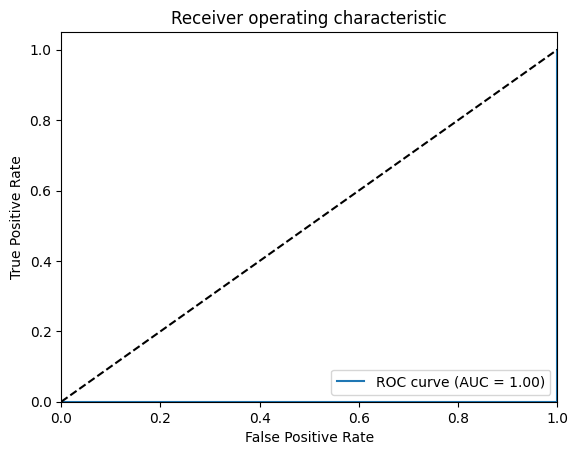

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_pred_proba = knn.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label='index')

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc_score(y_test, y_pred_proba))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


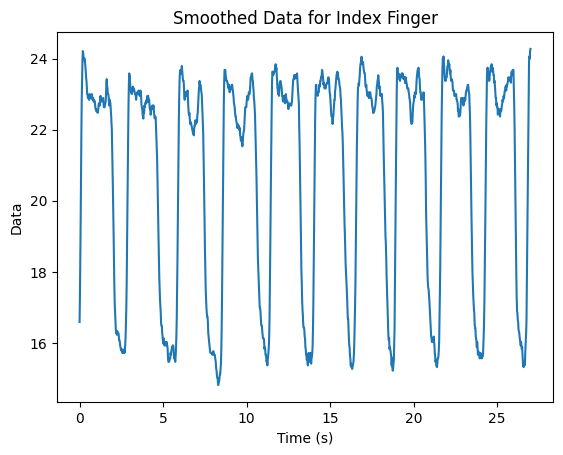

In [ ]:
import matplotlib.pyplot as plt

# Select the first gesture from the gesturedata DataFrame
gesture = gesturedata.iloc[0]

# Plot the smoothed data against time
plt.plot(gesture['time'], gesture['smooth_data'])
plt.xlabel('Time (s)')
plt.ylabel('Data')
plt.title('Smoothed Data for Index Finger')
plt.show()


[16.59, 17.31, 18.34, 19.43, 20.73, 21.92, 22.9, 23.48, 23.95, 24.21, 24.16, 24.0, 23.95, 24.0, 24.0, 23.9, 23.79, 23.63, 23.47, 23.37, 23.21, 23.0, 23.0, 22.89, 22.89, 22.95, 22.84, 22.84, 23.0, 22.95, 22.89, 22.95, 22.95, 22.89, 23.0, 22.89, 22.84, 22.89, 22.84, 22.79, 22.84, 22.79, 22.79, 22.68, 22.58, 22.58, 22.52, 22.52, 22.52, 22.52, 22.47, 22.52, 22.63, 22.74, 22.74, 22.74, 22.68, 22.89, 22.95, 22.84, 22.79, 22.79, 22.84, 22.84, 22.84, 22.89, 22.74, 22.63, 22.63, 22.63, 22.68, 22.74, 22.79, 23.0, 23.32, 23.42, 23.21, 23.16, 23.0, 23.0, 22.95, 22.79, 22.68, 22.84, 22.79, 22.74, 22.58, 22.42, 22.21, 22.0, 21.48, 20.96, 20.29, 19.67, 19.0, 18.22, 17.55, 17.1, 16.84, 16.64, 16.38, 16.28, 16.33, 16.23, 16.33, 16.28, 16.28, 16.28, 16.23, 16.08, 16.08, 16.03, 15.93, 15.88, 15.82, 15.82, 15.77, 15.82, 15.72, 15.72, 15.72, 15.72, 15.72, 15.82, 15.72, 15.77, 15.98, 16.18, 16.54, 17.0, 17.71, 18.8, 19.88, 20.87, 21.8, 22.69, 23.26, 23.58, 23.53, 23.37, 23.21, 23.16, 23.05, 23.05, 23.0, 23.

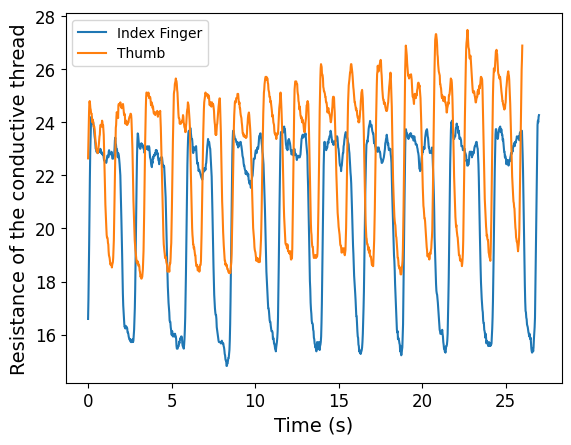

In [ ]:
# Assign the time values for each subject's index finger and thumb to x1, x2, x3, x4
x1 = gesturedata['time'][0]
x2 = gesturedata['time'][12]

# Assign the corresponding smooth data values for each subject's index finger and thumb to y1, y2, y3, y4
y1 = gesturedata['smooth_data'][0]
y2 = gesturedata['smooth_data'][12]

print(y1)
# Plot both data sets on the same subplot using Seaborn's lineplot function
sns.lineplot(x=x1, y=y1, label='Index Finger')
sns.lineplot(x=x2, y=y2, label='Thumb')

# Add a legend to the plot
plt.legend()

# Add a title to the figure
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Resistance of the conductive thread', fontsize=14)
#plt.title('Smoothed Data for Index and Thumb', fontsize=18)

# Increase font size of x and y axis values
plt.tick_params(axis='both', which='major', labelsize=12)

# Show the figure
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# y_true: true labels, y_pred: predicted labels
y_true = [0, 1, 0, 1, 1]
y_pred = [0, 1, 1, 0, 1]

# Compute the metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Set font size of y-axis tick labels
#plt.yticks(fontsize=14)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.6
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F1-score: 0.6666666666666666


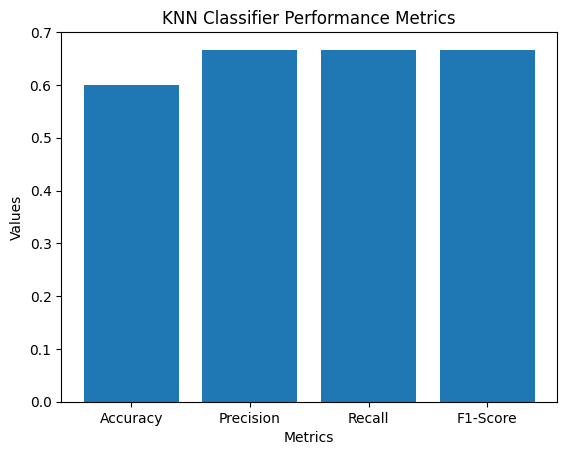

In [ ]:
import matplotlib.pyplot as plt

# Metrics values
accuracy = 0.6
precision = 0.6666666666666666
recall = 0.6666666666666666
f1_score = 0.6666666666666666

# Create a bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1_score]
plt.bar(metrics, values)

# Set the chart title and labels
plt.title('KNN Classifier Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')

# Show the chart
plt.show()


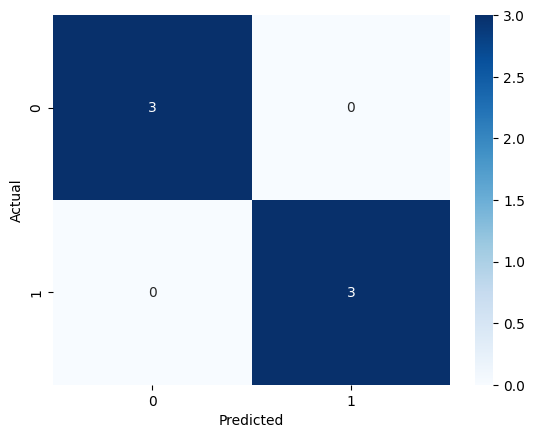

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# define the confusion matrix values
cm = [[3, 0], [0, 3]]

# create the heatmap for the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

# set the x-axis and y-axis labels
plt.xlabel('Predicted')
plt.ylabel('Actual')

# show the plot
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# True values
y_true = [1, 1, 0, 0, 1, 1]

# Predicted values
y_pred = [1, 1, 0, 0, 1, 1]

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision
precision = precision_score(y_true, y_pred)

# Calculate recall
recall = recall_score(y_true, y_pred)

# Calculate F1-score
f1 = f1_score(y_true, y_pred)

# Print results
print("Confusion matrix:\n", cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Confusion matrix:
 [[2 0]
 [0 4]]
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


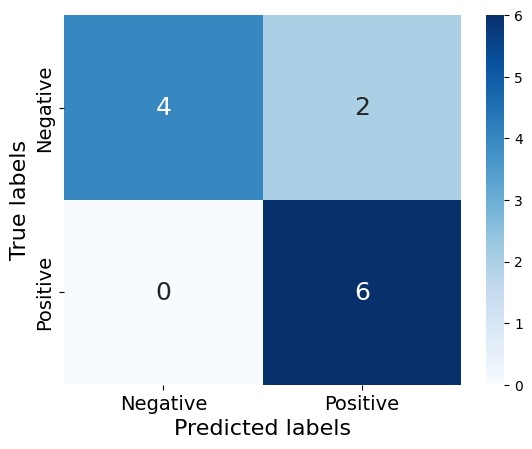

In [ ]:
y_pred = knn.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
ax = plt.subplot()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=ax, annot_kws={"fontsize":18})

# Add labels, title, and axis ticks with larger font size
ax.set_xlabel('Predicted labels', fontsize=16)
ax.set_ylabel('True labels', fontsize=16)
#ax.set_title('Confusion Matrix', fontsize=18)
ax.xaxis.set_ticklabels(['Negative', 'Positive'], fontsize=14)
ax.yaxis.set_ticklabels(['Negative', 'Positive'], fontsize=14)

plt.show()



#Final: KNN

In [ ]:
# Extract statistical features from the time series data
def extract_features(data):
    features = []
    features.append(np.mean(data))
    features.append(np.std(data))
    features.append(np.median(data))
    features.append(np.max(data))
    features.append(np.min(data))
    features.append(np.sum(data))
    features.append(np.abs(data).mean())
    features.append(np.abs(data).std())
    features.append(np.abs(data).sum())
    return features

# Create a new dataframe with the extracted features
feature_data = pd.DataFrame(columns=['mean', 'std', 'median', 'max', 'min', 'sum', 'mean_abs', 'std_abs', 'sum_abs'])
for i in range(len(gesturedata)):
    feature_row = extract_features(gesturedata['smooth_data'][i])
    feature_data.loc[i] = feature_row

# Define the label values as a list
label_values = ['index', 'index', 'index', 'index', 'index', 'index', 'index', 'index', 'index', 'index', 'index', 'thumb', 'thumb', 'thumb', 'thumb', 'thumb', 'thumb', 'thumb', 'thumb', 'thumb', 'thumb', 'thumb']


# Add a new column to the feature dataframe with the label values
feature_data['label'] = label_values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_data.drop('label', axis=1), feature_data['label'], test_size=0.5, random_state=42)

# Train the KNN classifier with the training data
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict the labels of the test data
y_pred = knn.predict(X_test)

# Print the accuracy score of the model
#accuracy = knn.score(X_test, y_test)
#print('Accuracy:', accuracy)



NameError: ignored

In [ ]:
feature_data

In [ ]:
# create a new data point
new_data = [23.337210, 5.420744, 25.220, 31.85, 15.02, 28774.78, 23.337210, 5.420744, 28774.78]

# predict the label using the trained KNN classifier
predicted_label = knn.predict([new_data])

# print the predicted label
print('Predicted Label:', predicted_label)

# Final: Confusion Matrix & ROC curve

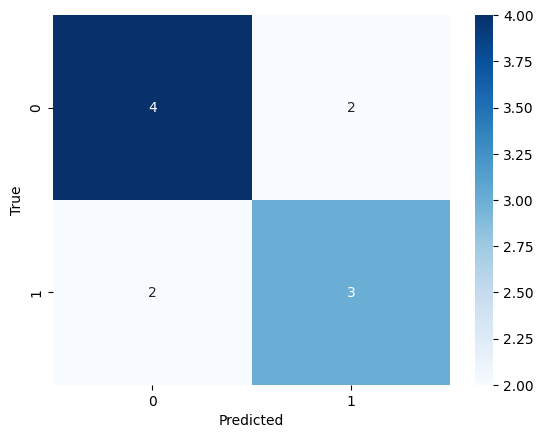

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

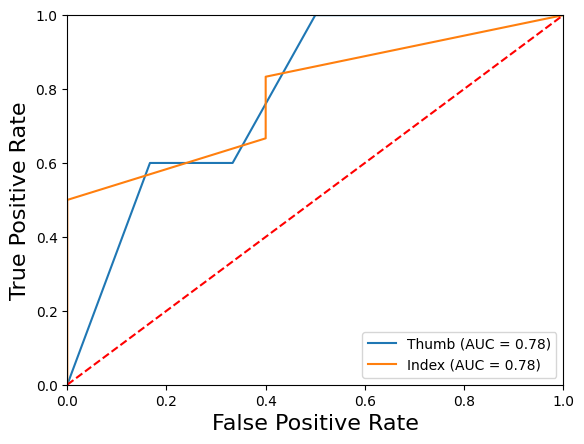

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Compute the ROC curve and area under the curve (AUC) for thumb
fpr_thumb, tpr_thumb, thresholds_thumb = roc_curve(y_test, knn.predict_proba(X_test)[:, 1], pos_label='thumb')
roc_auc_thumb = auc(fpr_thumb, tpr_thumb)

# Compute the ROC curve and area under the curve (AUC) for index
fpr_index, tpr_index, thresholds_index = roc_curve(y_test, knn.predict_proba(X_test)[:, 0], pos_label='index')
roc_auc_index = auc(fpr_index, tpr_index)

# Plot the ROC curve for both classes
plt.plot(fpr_thumb, tpr_thumb, label='Thumb (AUC = %0.2f)' % roc_auc_thumb)
plt.plot(fpr_index, tpr_index, label='Index (AUC = %0.2f)' % roc_auc_index)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
#plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
